# -----------------------------------------------------
# Raiders of the Lost Plateau 
## WALLS - 34Nodes  (x2Box)
### Created : November 2018
# -----------------------------------------------------

## Notes

1. Not trying to obtain a smooth matrix $C(t)$ converting to zero the eigenvalues below a cutoff value. The matrix $\Lambda(t)$ calculated after it is worst than the obtained with the original $C(t)$.

2. There is no difference in $C^{-1}(t)$ when *rcond* is changed.

3. Compute the integral of the correlations using the trapezoidal rule instead of the operator: 

  \begin{array}{cccc}
   1 & 0 & 0 & 0\\
   1 & 1 & 0 & 0\\
   1 & 1 & 1 & 0\\
   1 & 1 & 1 & 1\\
  \end{array}

    With the trapezoidal rule we obtain "better results" of the transport coefficientes to probe the theorem: 

    $\dot{C}(t) = -k_B T M(t) = -k_B ·T·[F^T·\eta(t)·F + G(t)·F + F^T·H(t) + \gamma(t)]$
    
4. Because of the method used in order to build the matrices of correlations (we only compute two blocks of correlations) the components of the bulk will sense the effect of the walls after a certain time. This time can be calculated as a time of diffusion $t$~$L^2/\nu$ or plotting together the correlation in the middle of the canal compute directly with LAMMPS and the same component of the correlation obtained from the blocks. 

# 0. INTRO

## 0.1. Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
from scipy.linalg import expm
from numpy import linalg as LA
from numpy.linalg import inv
import scipy.integrate as integrate
from IPython.display import Image

## 0.2. Plot style

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
#Uncomment to interact with the plots
#import mpld3
#mpld3.enable_notebook()

## 0.3. Load files

In [3]:
Ct   = np.loadtxt('Ct-x2Box-WALLS.dat') 

## 0.4. Parameters

In [4]:
Lx, Ly, Lz = 40.0, 40.0, 68.0   
nNodes     = 34
dz         = Lz / nNodes
VBin       = Lx * Ly * dz
SBin       = Lx * Ly
nSteps     = np.shape(Ct)[0]
nCols      = np.shape(Ct)[1]
dt         = 0.004
tol        = 1e-3
nBlocks    = 1                                                            
nVar       = int(np.sqrt(nBlocks))                      
dim        = nVar * nNodes 
Temp       = 2.0
F          = (1 / dz) * (-(np.eye(nNodes)) + np.eye(nNodes, nNodes, 1))
FInv       = inv(F)
Laplacian  = (1 / dz**2) * (-2 * (np.eye(nNodes)) +\
             np.eye(nNodes, nNodes, -nNodes+1) + np.eye(nNodes, nNodes, nNodes-1) +\
             np.eye(nNodes, nNodes, -1) + np.eye(nNodes, nNodes, 1))
xlimUpper  = nSteps * dt
tau        = 0.3

## 0.5. Subroutines

In [5]:
#Reshape from vector to matrix
def reshape_vm(A):
    B = A.reshape(nBlocks,nNodes*nNodes).reshape(nVar,nVar,nNodes,nNodes).transpose(0,2,1,3).reshape(dim,dim)
    return B

#Reshape from matrix to vector
def reshape_mv(A):
    B = A.reshape(nVar,nNodes,nVar,nNodes).swapaxes(1,2).ravel()
    return B

#Select the step to which a certain time corresponds
def step(t):
    step = int(round(t/dt))
    return step   

#Select the column to which the autocorrelation of a selected node corresponds
def col(nodeSelected):
    column = (nodeSelected - 1) * nNodes + nodeSelected - 1
    return column

#Replace all values in a matrix < cutOff with zero
def cutOff(A, cutOffValue):
    rows, cols =  np.shape(A)
    B = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            if abs(A[i,j]) > cutOffValue:
                B[i,j] = A[i,j]
            #if A[i,j] > cutOffValue:
             #   B[i,j] = A[i,j]
    return B

#Replace all values in a matrix equal to zero with NaN 
def zeroToNan(A):
    rows, cols =  np.shape(A)
    for i in range(rows):
        for j in range(cols):
            if A[i,j] == 0:
                A[i,j] = np.nan
    return A

def zeroedC(A, cutOffValue):
    rows, cols =  np.shape(A)
    B = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            if abs(A[i,j]) < cutOffValue:
                B[i,j] = 0
            if abs(A[i,j]) > cutOffValue:
                B[i,j] = A[i,j]
    return B

#Derivative and integral operators. The derivative is in compliance with the Barrow rule.
ODev      = np.identity(nSteps) - np.eye(nSteps, nSteps, -1) 
OInt      = np.tril(np.ones((nSteps, nSteps), dtype=float), 0) 
ODev[0,0] = 0
ODev /= dt
OInt *= dt

## 0.6. Convert $C(t)$ into an array of 3 dimensions 

In [6]:
Ct3D = np.zeros((nNodes, nNodes, nSteps))
#nNodes      = 33
#dim         = nVar * nNodes 
for k in range(nSteps):
    #Ct3D[1:,1:,k] = reshape_vm(Ct[k,:])  #Add row and column of zeros
    Ct3D[:,:,k] = reshape_vm(Ct[k,:])
Ct = Ct3D
#nNodes = 34
#dim    = nVar * nNodes

#### Save files

In [7]:
np.savetxt('../../filesGNUPLOT/C-t0.0-x2Box-WALLS.dat', Ct[:,:,step(0.0)])
np.savetxt('../../filesGNUPLOT/C-t0.2-x2Box-WALLS.dat', Ct[:,:,step(0.2)])
np.savetxt('../../filesGNUPLOT/C-t0.5-x2Box-WALLS.dat', Ct[:,:,step(0.5)])

## 0.7. Plot density profile

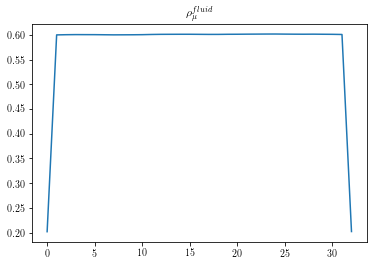

In [8]:
density = np.loadtxt('rhoProfile-34nodes.dat')
plt.plot(density)
plt.title(r'$\rho^{fluid}_{\mu}$')
plt.show()

# 1. REAL SPACE

## 1.1. Compute $\dot{C}_{\mu\nu}(t)$, $C^{-1}_{\mu\nu}(t)$, $ c_{\mu\nu}(t)$, $c^{-1}_{\mu\nu}(t)$ and $\Lambda_{\mu\nu}(t)$

In [9]:
CtDev     = np.zeros((nNodes, nNodes, nSteps))
CtInv     = np.zeros((nNodes, nNodes, nSteps))
CtNorm    = np.zeros((nNodes, nNodes, nSteps))
CtNormInv = np.zeros((nNodes, nNodes, nSteps))
Lambdat   = np.zeros((nNodes, nNodes, nSteps))

for i in range(nNodes):
    CtDev[i,:,:] = ODev.dot(Ct[i,:,:].T).T
    
for k in range(nSteps):
    CtInv[:,:,k]     = linalg.pinv(Ct[:,:,k], rcond = tol)
    CtNorm[:,:,k]    = CtInv[:,:,0].dot(Ct[:,:,k])
    CtNormInv[:,:,k] = linalg.pinv(CtNorm[:,:,k], rcond = tol)
    Lambdat[:,:,k]   = - CtDev[:,:,k].dot(CtInv[:,:,k])

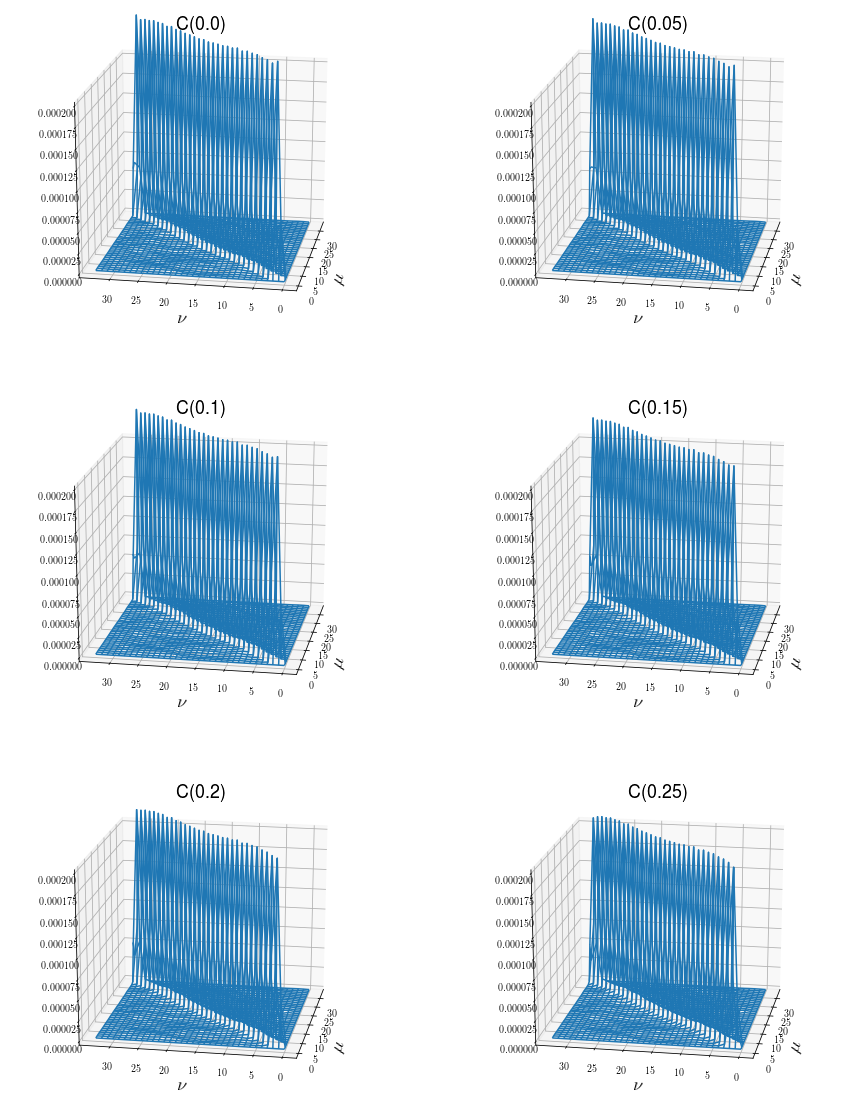

In [10]:
x = range(nNodes)
y = range(nNodes)

f  = plt.figure(figsize=(15,20))
p = 1
for t in np.arange(0, 0.3, 0.05):
    h = f.add_subplot(3,2,p, projection='3d')
    X, Y = np.meshgrid(x, y) 
    h.plot_wireframe(X, Y, Ct[:,:,step(t)])
    h.set_zlim(0,2e-4)
    h.set_title('C('+str(t)+')',fontsize=18)
    h.set_xlabel(r'$\mu$',fontsize=18)
    h.set_ylabel(r'$\nu$',fontsize=18)
    h.view_init(20, 190)
    p += 1
plt.show()

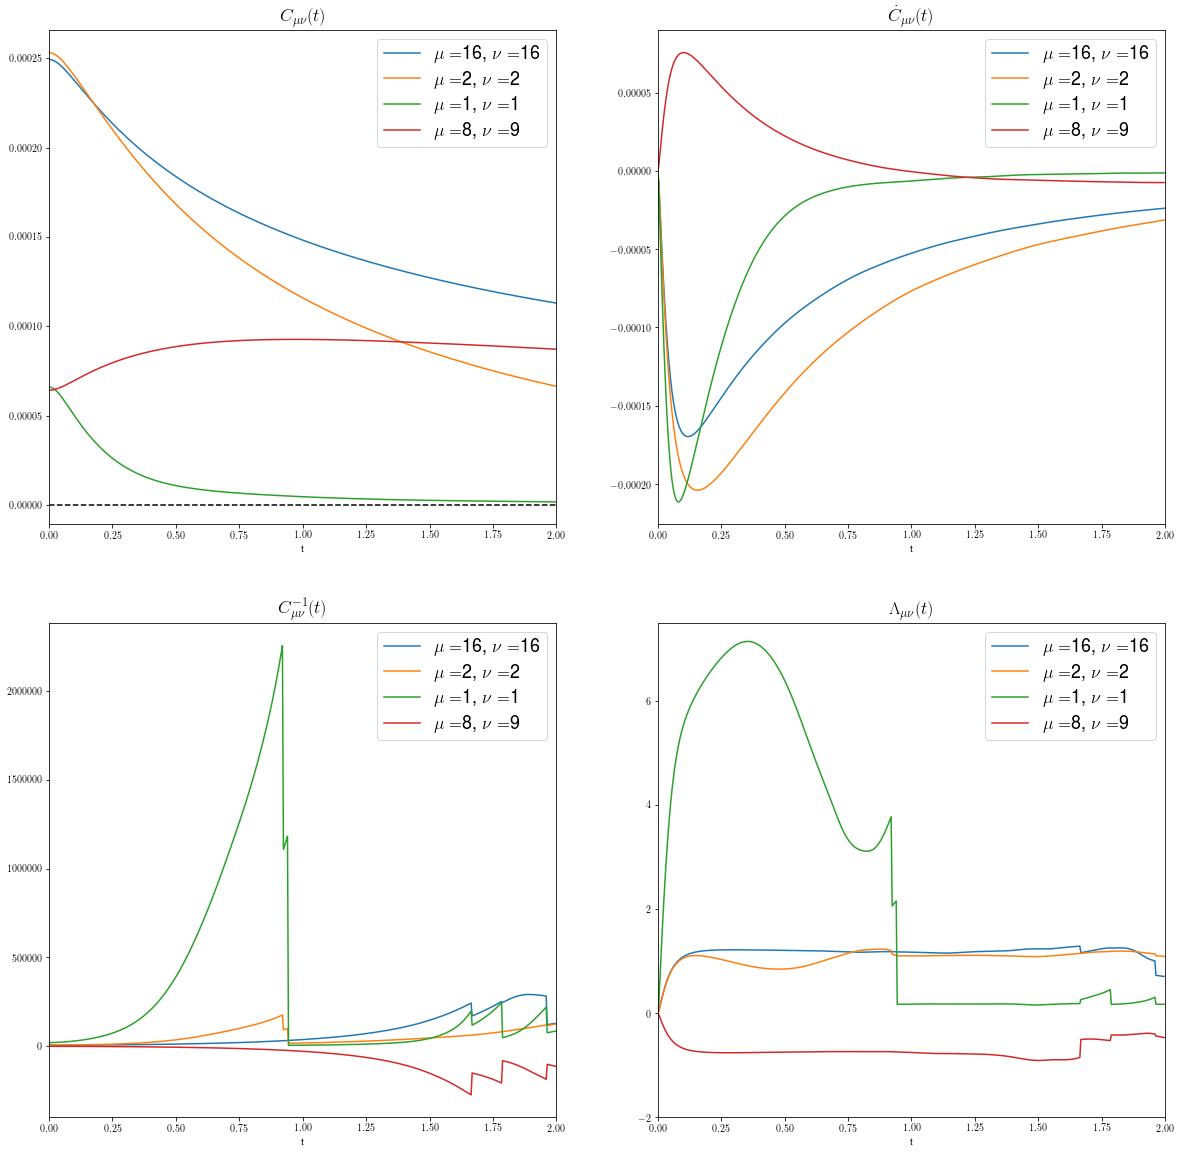

In [11]:
x = np.arange(0, nSteps * dt, dt)
plt.figure(1, figsize=(20,20))

plt.subplot(221)
plt.plot(x, Ct[16, 16, :], label = r'$\mu=$'+str(16)+r', $\nu=$'+str(16))
plt.plot(x, Ct[2, 2, :],   label = r'$\mu=$'+str(2)+r', $\nu=$'+str(2))
plt.plot(x, Ct[1, 1, :],   label = r'$\mu=$'+str(1)+r', $\nu=$'+str(1))
plt.plot(x, Ct[8, 9, :],   label = r'$\mu=$'+str(8)+r', $\nu=$'+str(9))
plt.axhline(y=0, color='k', linestyle='--')
plt.xlim(0,xlimUpper)
plt.title(r'$C_{\mu \nu}(t)$',fontsize=18)
plt.xlabel('t')
plt.legend(loc='upper right',fontsize=18)

plt.subplot(222)
plt.plot(x, CtDev[16, 16, :], label = r'$\mu=$'+str(16)+r', $\nu=$'+str(16))
plt.plot(x, CtDev[2, 2, :],   label = r'$\mu=$'+str(2)+r', $\nu=$'+str(2))
plt.plot(x, CtDev[1, 1, :],   label = r'$\mu=$'+str(1)+r', $\nu=$'+str(1))
plt.plot(x, CtDev[8, 9, :],   label = r'$\mu=$'+str(8)+r', $\nu=$'+str(9))
plt.xlim(0,xlimUpper)
plt.title(r'$\dot{C}_{\mu \nu}(t)$',fontsize=18)
plt.xlabel('t')
plt.legend(loc='upper right',fontsize=18)

plt.subplot(223)
plt.plot(x, CtInv[16, 16, :], label = r'$\mu=$'+str(16)+r', $\nu=$'+str(16))
plt.plot(x, CtInv[2, 2, :],   label = r'$\mu=$'+str(2)+r', $\nu=$'+str(2))
plt.plot(x, CtInv[1, 1, :],   label = r'$\mu=$'+str(1)+r', $\nu=$'+str(1))
plt.plot(x, CtInv[8, 9, :],   label = r'$\mu=$'+str(8)+r', $\nu=$'+str(9))
plt.xlim(0,xlimUpper)
plt.title(r'$C_{\mu \nu}^{-1}(t)$',fontsize=18)
plt.xlabel('t')
plt.legend(loc='upper right',fontsize=18)

plt.subplot(224)
plt.plot(x, Lambdat[16, 16, :], label = r'$\mu=$'+str(16)+r', $\nu=$'+str(16))
plt.plot(x, Lambdat[2, 2, :],   label = r'$\mu=$'+str(2)+r', $\nu=$'+str(2))
plt.plot(x, Lambdat[1, 1, :],   label = r'$\mu=$'+str(1)+r', $\nu=$'+str(1))
plt.plot(x, Lambdat[8, 9, :],   label = r'$\mu=$'+str(8)+r', $\nu=$'+str(9))
plt.xlim(0,xlimUpper)
plt.ylim(-2,7.5)
plt.title(r'$\Lambda_{\mu \nu}(t)$',fontsize=18)
plt.xlabel('t')
plt.legend(loc='upper right',fontsize=18)
plt.show()

# 2. RECIPROCAL SPACE
Because of the translational invariance, in PBC we can take the Fourier Transform of the matrices in order to diagonalized them. This property is broken when the system consisting on a fluid in contact with solid slabs. Therefore, we need to obtain the basis, $E$, which diagonalized the matrices when the system is not periodic. 

The ideal basis would be the one which diagonalizes $\Lambda(t)$ at each time step, but $\Lambda(t)$ is a function of $C^{-1}(t)$ (blows up at $t=0.8$). 

The route followed is to compute the basis of eigenvectors of $C(t)$ at each time step, $E(t)$. We also compute the basis at t=0.15, $E(0.15)$ and t=0.30, $E(0.30)$, to prove that $E$ has a *plateau* (we will show that $\tilde{\Lambda}(t)$ is very similar computed in the three basis). 

## 2.1. Compute $\tilde{C}(t)$, $\tilde{\dot{C}}(t)$, $\tilde{C}^{-1}(t)$, $\tilde{c}(t)$, $\tilde{c}^{-1}(t)$ and $\tilde{\Lambda}(t)$ with $E(t)$, $E(0.15)$, $E(0.30)$ 

In [12]:
#Compute and sort eigenvalues and eigenvectors of C at t=0.15 and t=0.30 
w015, v015 = LA.eig(Ct[:,:,step(0.15)])
idx        = w015.argsort()[::-1]   
w015       = w015[idx]
v015       = v015[:,idx]
w030, v030 = LA.eig(Ct[:,:,step(0.30)])
idx        = w030.argsort()[::-1]   
w030       = w030[idx] 
v030       = v030[:,idx]

CtRec         = np.zeros((nNodes, nNodes, nSteps))
CtDevRec      = np.zeros((nNodes, nNodes, nSteps))
CtDevRec015   = np.zeros((nNodes, nNodes, nSteps))
CtDevRec030   = np.zeros((nNodes, nNodes, nSteps))
CtInvRec      = np.zeros((nNodes, nNodes, nSteps))
CtNormRec     = np.zeros((nNodes, nNodes, nSteps))
CtNormInvRec  = np.zeros((nNodes, nNodes, nSteps))
LambdatRec    = np.zeros((nNodes, nNodes, nSteps))
LambdatRec015 = np.zeros((nNodes, nNodes, nSteps))
LambdatRec030 = np.zeros((nNodes, nNodes, nSteps))
vt            = np.zeros((nNodes, nNodes, nSteps))
wt            = np.zeros((nSteps, nNodes))

for k in range(nSteps):
    #Compute and sort eigenvalues and eigenvector of C(t) at each time step
    w, v      = LA.eig((Ct[:,:,k]))
    idx       = w.argsort()[::-1]   
    w         = w[idx]
    v         = v[:,idx]
    wt[k,:]   = w
    vt[:,:,k] = v
    #Compute C(t), CDev(t), CInv(t), CNorm(t), CNormInv(t) and Lambda(t) 
    #in the reciprocal space of C(t)
    CtRec[:,:,k]        = inv(v).dot(Ct[:,:,k]).dot(v)
    CtDevRec[:,:,k]     = inv(v).dot(CtDev[:,:,k]).dot(v)
    CtDevRec015[:,:,k]     = inv(v015).dot(CtDev[:,:,k]).dot(v015)
    CtDevRec030[:,:,k]     = inv(v030).dot(CtDev[:,:,k]).dot(v030)
    CtInvRec[:,:,k]     = inv(v).dot(CtInv[:,:,k]).dot(v)
    CtNormRec[:,:,k]    = inv(v).dot(CtNorm[:,:,k]).dot(v)
    CtNormInvRec[:,:,k] = inv(v).dot(CtNormInv[:,:,k]).dot(v)
    LambdatRec[:,:,k]   = inv(v).dot(Lambdat[:,:,k]).dot(v)
    #Lambda(t) in the reciprocal space of C(0.15) and C(0.30)
    LambdatRec015[:,:,k] = inv(v015).dot(Lambdat[:,:,k]).dot(v015)
    LambdatRec030[:,:,k] = inv(v030).dot(Lambdat[:,:,k]).dot(v030)

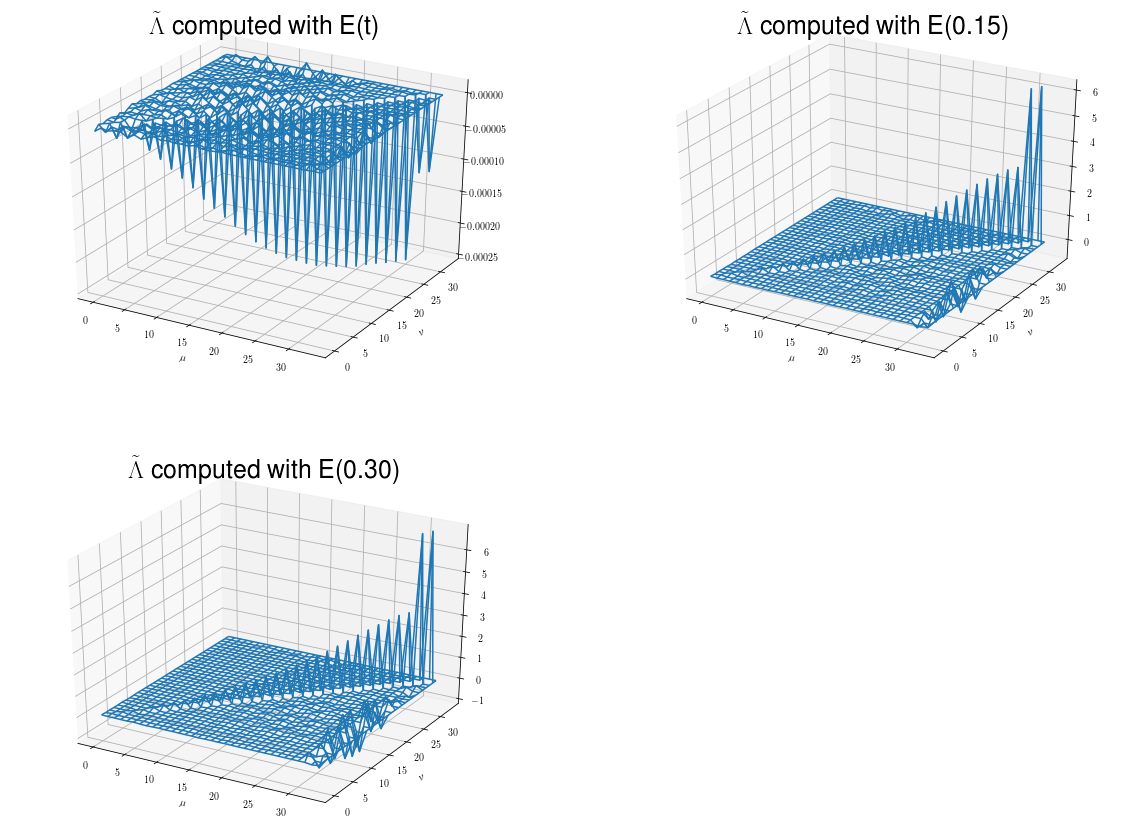

In [13]:
x = range(nNodes)
y = range(nNodes)
f  = plt.figure(figsize=(20,15))
X, Y = np.meshgrid(x, y)
ha = f.add_subplot(2,2,1, projection='3d')
ha.plot_wireframe(X, Y, CtDevRec[:,:,step(0.20)])
ha.set_title(r'$\tilde{\Lambda}$ computed with E(t)',fontsize=25)
ha.set_xlabel(r'$\mu$')
ha.set_ylabel(r'$\nu$')

hb = f.add_subplot(2,2,2, projection='3d')
hb.plot_wireframe(X, Y, LambdatRec015[:,:,step(0.15)])
hb.set_title(r'$\tilde{\Lambda}$ computed with E(0.15)',fontsize=25)
hb.set_xlabel(r'$\mu$')
hb.set_ylabel(r'$\nu$')

hb = f.add_subplot(2,2,3, projection='3d')
hb.plot_wireframe(X, Y, LambdatRec030[:,:,step(0.30)])
hb.set_title(r'$\tilde{\Lambda}$ computed with E(0.30)',fontsize=25)
hb.set_xlabel(r'$\mu$')
hb.set_ylabel(r'$\nu$')

plt.show()

In [14]:
# Lambda tilde debería ser diagonal. Los errores son del cálculo de la derivada (grafica de la derivada en recíproco)

### 2.1.2. The *plateau* of $\Lambda(t)$
We show the matrix $\tilde{\Lambda}(t)$ calculated with three basis of eigenvectors. The plot allows us to infer that we may choose the basis of eigenvector in each time, $E(t)$, because it seems time-independent

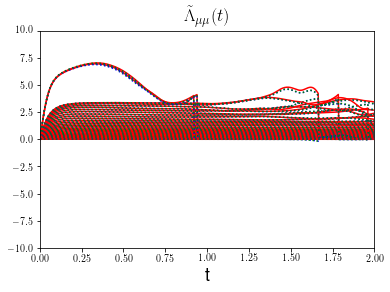

In [15]:
x = np.arange(0, nSteps * dt,dt)

for i in range(nNodes):
    plt.plot(x, LambdatRec[i,i,:], 'r')
    plt.plot(x, LambdatRec015[i,i,:], ':b')
    plt.plot(x, LambdatRec030[i,i,:], ':g')
plt.title(r'$\tilde{\Lambda}_{\mu\mu}(t)$',fontsize=18)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)
plt.ylim(-10,10)
plt.show()

### 2.1.3. Plot eigenvectors and eigenvalues

30
31
32
33


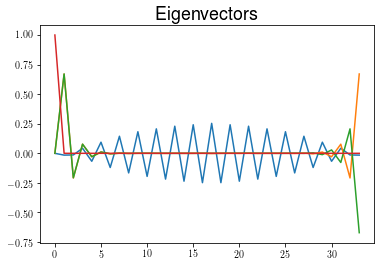

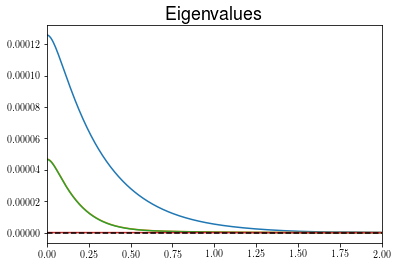

In [16]:
#f  = plt.figure(figsize=(15,11))
for i in np.arange(30,nNodes,1):
    print i
    plt.plot(vt[:,i,step(0.12)], label=str(i+1))
plt.title('Eigenvectors',fontsize=18)
#plt.legend(loc='upper right',fontsize=15)
plt.show()

x = np.arange(0, nSteps*dt, dt)
for i in np.arange(30,nNodes,1):
    plt.plot(x, wt[:,i], label=str(i+1))
plt.title('Eigenvalues',fontsize=18)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlim(0,2)
#plt.legend(loc='upper right',fontsize=15)
plt.show()

## 2.3. Plot $\tilde{C}_{\mu\mu}$, $\tilde{\dot{C}}_{\mu\mu}$, $\tilde{C}^{-1}_{\mu\mu}$, $\tilde{\Lambda}_{\mu\mu}$, $\tilde{c}_{\mu\mu}$, $\tilde{c}^{-1}_{\mu\mu}$ and $\bar{\tilde{C}}_{\mu\mu}$

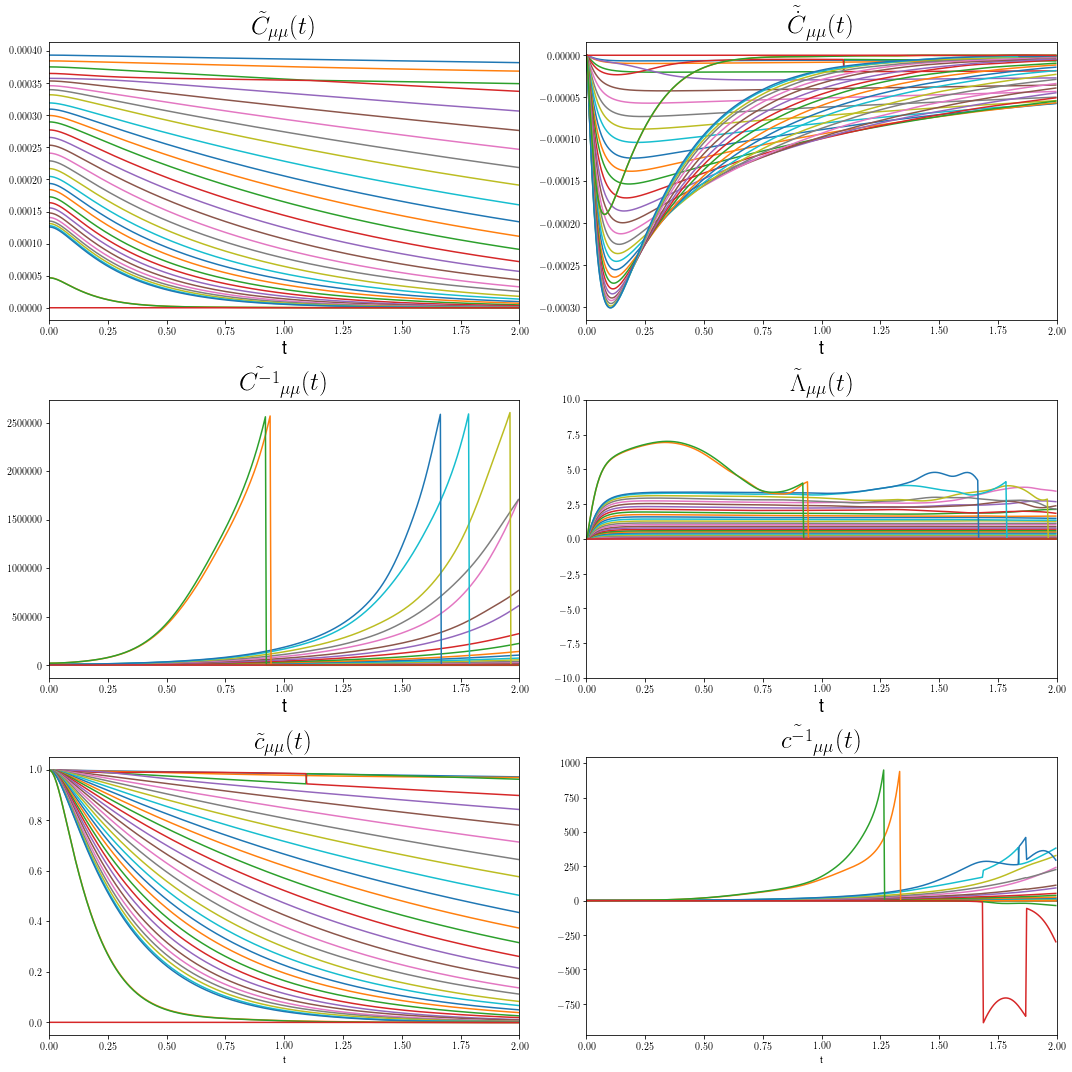

In [17]:
x = np.arange(0, nSteps * dt, dt)

plt.figure(1, figsize=(15,15))

plt.subplot(321)
for i in range(nNodes):
    plt.plot(x, CtRec[i,i,:])
plt.title(r'$\tilde{C}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)
plt.legend(loc='upper right',fontsize=18)
#plt.ylim(0,)


plt.subplot(322)
for i in range(nNodes):
    plt.plot(x, CtDevRec[i,i,:])
plt.title(r'$\tilde{\dot{C}}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)


plt.subplot(323)
for i in range(nNodes):
    plt.plot(x, CtInvRec[i,i,:])
plt.title(r'$\tilde{C^{-1}}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)
#plt.ylim(0,)


plt.subplot(324)
for i in range(nNodes):
    plt.plot(x, LambdatRec[i,i,:])
plt.title(r'$\tilde{\Lambda}_{\mu\mu}(t)$',fontsize=25)
plt.ylim(-10,10)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)
#plt.ylim(0,30)

plt.subplot(325)
for i in range(nNodes):
    plt.plot(x, CtNormRec[i,i,:])
    #plt.plot(x, np.ones(nSteps) * cutOffValue, 'k')
plt.title(r'$\tilde{c}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t')
plt.xlim(0,2)
#plt.ylim(0,)

plt.subplot(326)
for i in range(nNodes):
    plt.plot(x, CtNormInvRec[i,i,:])
plt.title(r'$\tilde{c^{-1}}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t')
plt.xlim(0,2)
#plt.ylim(0,)


plt.tight_layout() #Improve spacing between subplots
plt.show()

#### Save files 

## 2.2. Chop $\tilde{C}(t)$ $\to$ $\bar{\tilde{C}}(t)$

Convert to zero all values of $\tilde{C}(t)$ smaller than a cut-off value.

In [18]:
cutOffValue = 5e-6

CtRecChop       = np.zeros((nNodes, nNodes, nSteps))
CtDevRecChop    = np.zeros((nNodes, nNodes, nSteps))
CtInvRecChop    = np.zeros((nNodes, nNodes, nSteps))
LambdatRecChop  = np.zeros((nNodes, nNodes, nSteps))
KinVisctRecChop = np.zeros((nNodes, nNodes, nSteps))
EtatRecChop     = np.zeros((nNodes, nNodes, nSteps))

for k in range(nSteps):
    CtRecChop[:,:,k] = cutOff((CtRec[:,:,k]), cutOffValue)

for i in range(nNodes):
    CtDevRecChop[i,:,:] = ODev.dot(CtRecChop[i,:,:].T).T

for k in range(nSteps):
    CtInvRecChop[:,:,k]    = linalg.pinv(CtRecChop[:,:,k], rcond = tol)
    LambdatRecChop[:,:,k]  = - CtDevRecChop[:,:,k].dot(CtInvRecChop[:,:,k])

#Convert zeros to NaN's 
for k in range(nSteps):
    CtRecChop[:,:,k]       = zeroToNan(CtRecChop[:,:,k])
    CtDevRecChop[:,:,k]    = zeroToNan(CtDevRecChop[:,:,k])
    CtInvRecChop[:,:,k]    = zeroToNan(CtInvRecChop[:,:,k])
    LambdatRecChop[:,:,k]  = zeroToNan(LambdatRecChop[:,:,k])

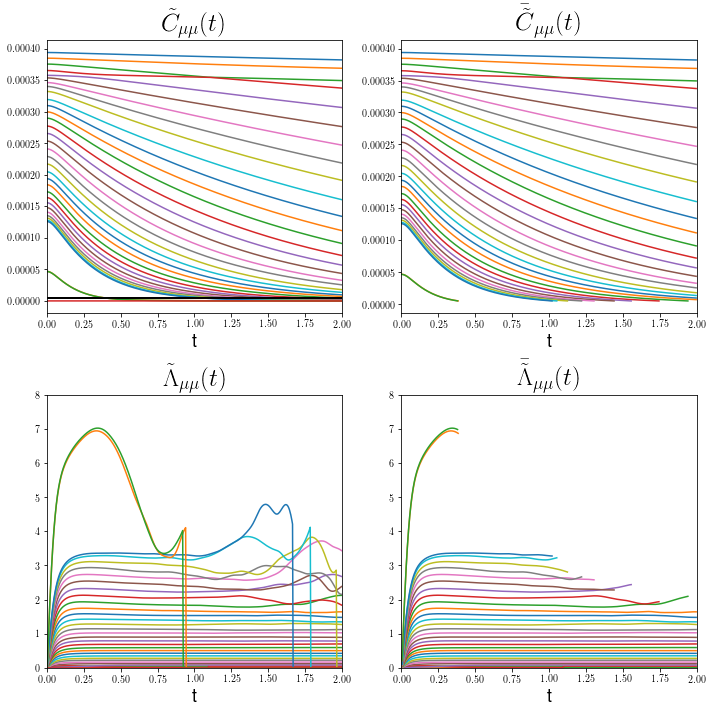

In [19]:
x = np.arange(0, nSteps * dt, dt)

plt.figure(1, figsize=(10,10))

plt.subplot(221)
for i in range(nNodes):
    plt.plot(x, CtRec[i,i,:])
    plt.plot(x, np.ones(nSteps) * cutOffValue, 'k')
plt.title(r'$\tilde{C}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)
plt.legend(loc='upper right',fontsize=18)
#plt.ylim(0,)

plt.subplot(222)
for i in range(nNodes):
    plt.plot(x, CtRecChop[i,i,:])
plt.title(r'$\bar{\tilde{C}}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)
#plt.ylim(0,)

plt.subplot(223)
for i in range(nNodes):
    plt.plot(x, LambdatRec[i,i,:])
plt.title(r'$\tilde{\Lambda}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)
plt.ylim(0,8)

plt.subplot(224)
for i in range(nNodes):
    plt.plot(x, LambdatRecChop[i,i,:])
plt.title(r'$\bar{\tilde{\Lambda}}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=18)
plt.xlim(0,2)
plt.ylim(0,8)

plt.tight_layout() #Improve spacing between subplots
plt.show()

#### Save files

# 3. PREDICTIONS 

From the figures we may considerer that $\tilde{\Lambda}(t)$ has a plateau. We select $\tau=0.25$ as the best compromise satisfaying that $\Lambda(t)$ has attained its constant value. Therefore 

$C^{predict}(t) = exp[-\Lambda(\tau)·(t-\tau)]C(\tau)$ 

## 3.1. Compute predictions

In [20]:
CtPredict  = np.zeros((nNodes, nNodes, nSteps))
for k in range(nSteps):
    t = k * dt
    CtPredict[:,:,k] = expm(- Lambdat[:,:,step(tau)] * (t - tau)).dot(Ct[:,:,step(tau)])

#### Save files

## 3.3 Plot $C(t)$ and the predictions

/home/diego/anaconda2/lib/python2.7/site-packages/matplotlib/ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


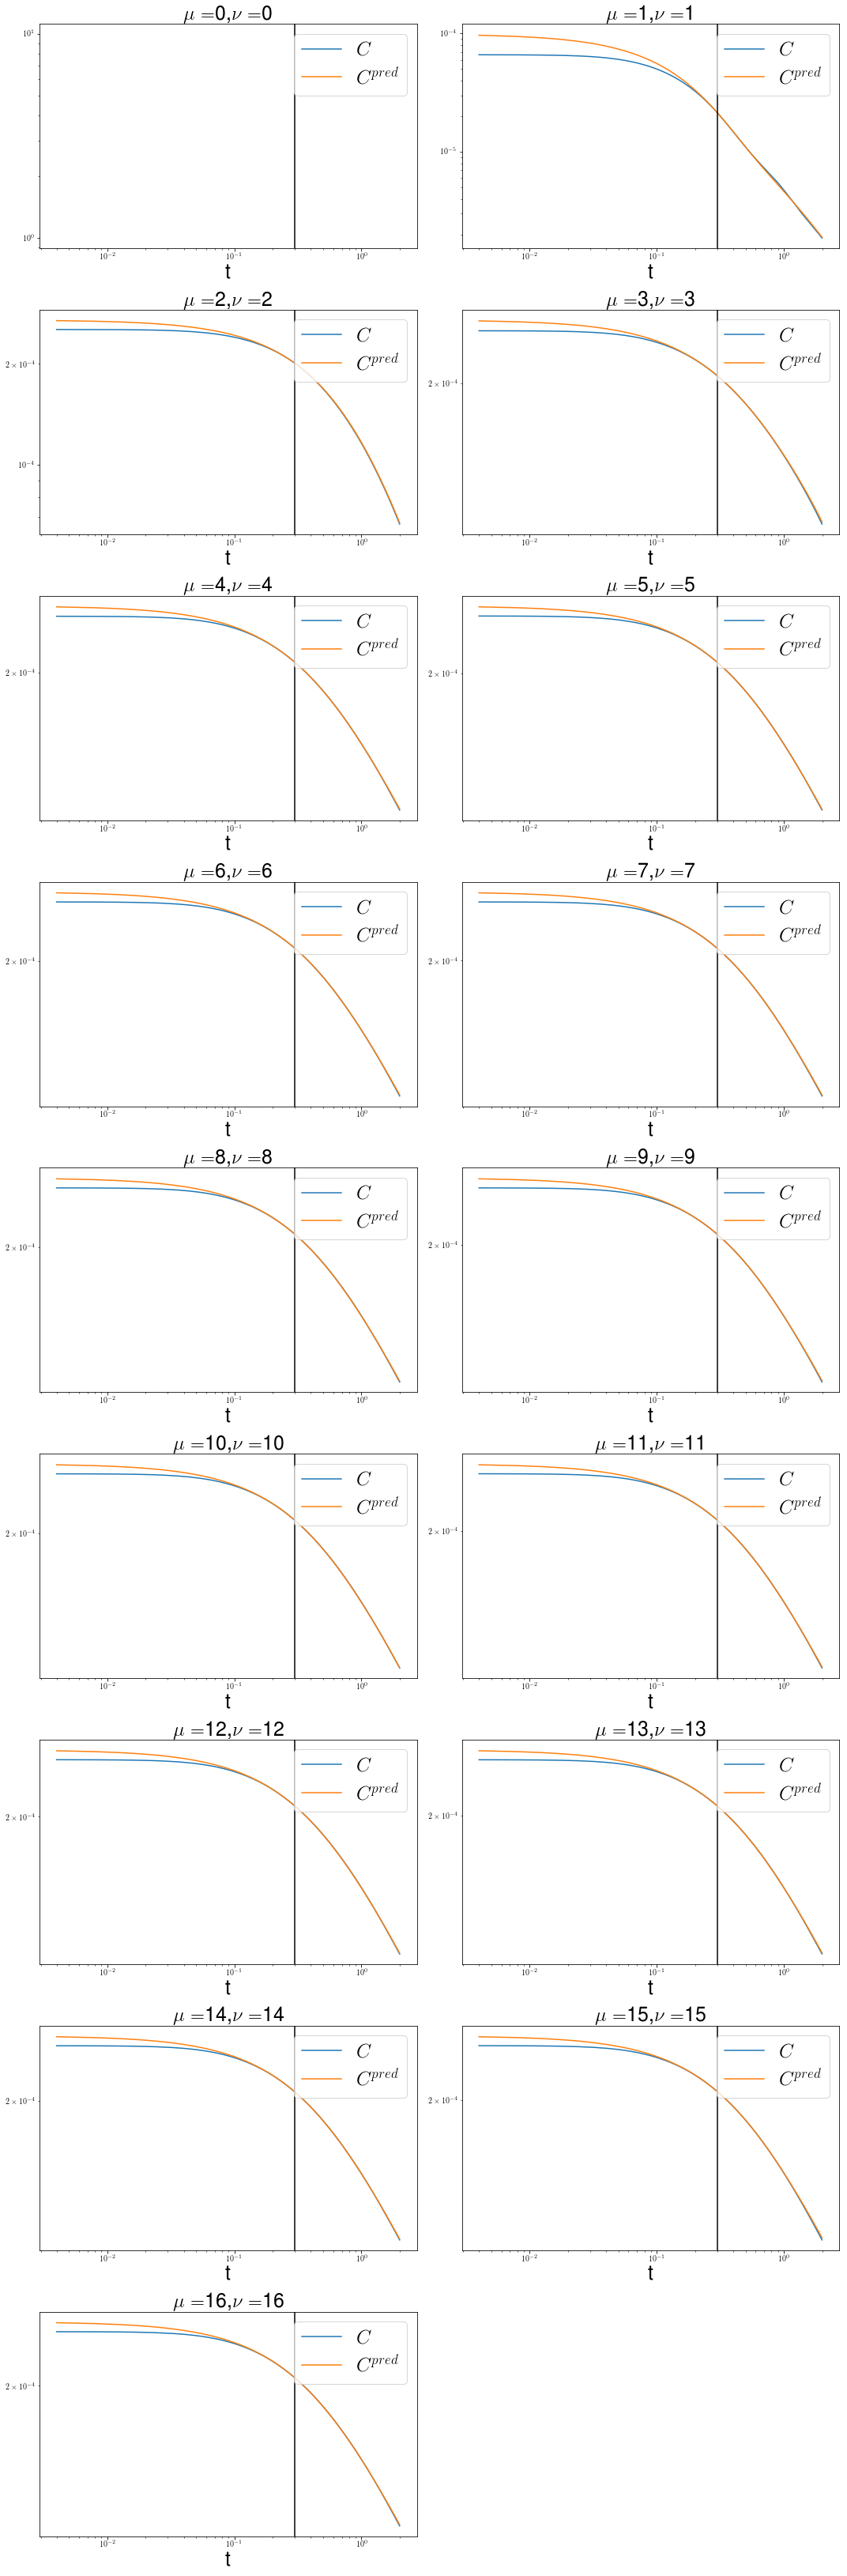

In [21]:
x = np.arange(0, nSteps * dt, dt)
plt.figure(1, figsize=(15,90))

nColumns = 2
nLines = nNodes / 2 + 1

for i in range(nNodes/2):
    plt.subplot(nLines,nColumns,i+1)
    plt.loglog(x, Ct[i,i,:], label='$C$')
    plt.loglog(x, CtPredict[i,i,:], label=r'$C^{pred}$')
    plt.title(r'$\mu=$'+str(i)+r',$\nu=$'+str(i),fontsize=25)
    plt.xlabel('t',fontsize=25)
    plt.legend(loc='upper right',fontsize=25)
    plt.axvline(x=tau, color='black')
plt.tight_layout() #Improve spacing between subplots
plt.show()

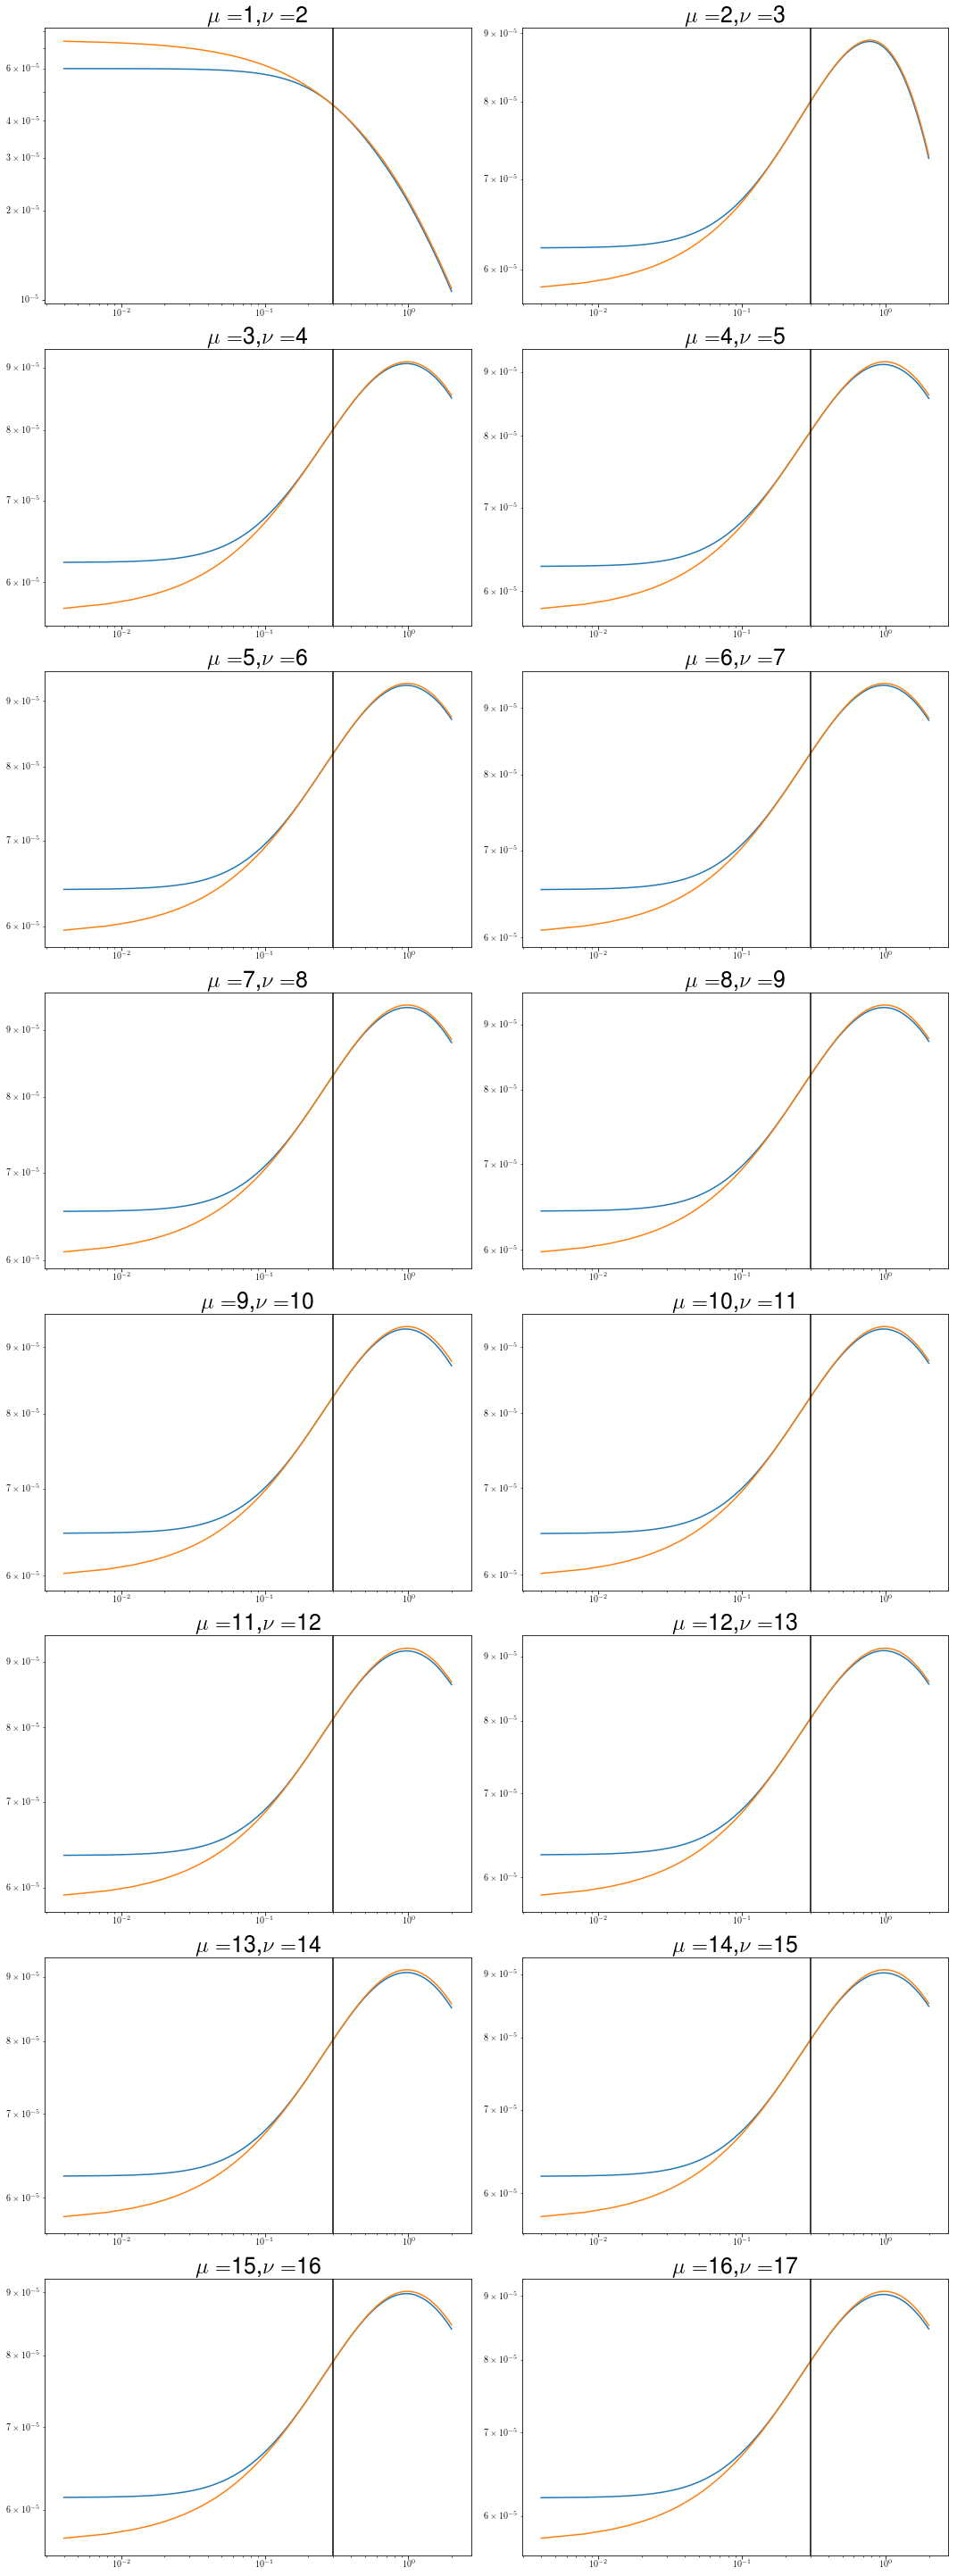

In [22]:
x = np.arange(0, nSteps * dt, dt)
plt.figure(1, figsize=(15,90))

nColumns = 2
nLines = nNodes / 2 + 1

for i in np.arange(1,nNodes/2,1):
    plt.subplot(nLines,nColumns,i)
    plt.loglog(x, Ct[i,i+1,:], label='$C$')
    plt.loglog(x, CtPredict[i,i+1,:], label=r'$C^{pred}$')
    plt.title(r'$\mu=$'+str(i)+r',$\nu=$'+str(i+1),fontsize=25)
    plt.axvline(x=tau, color='black')
    
plt.tight_layout() #Improve spacing between subplots
plt.show()

#### Save files

# 4. TRANSPORT KERNELS 

## 4.1. Files

In [23]:
Sxzt   = np.loadtxt('SxzSxz-x2Box-WALLS.dat') 
FxSxzt = np.loadtxt('FxSxz-x2Box-WALLS.dat')
SxzFxt = np.loadtxt('SxzFx-x2Box-WALLS.dat') 
Fxt    = np.loadtxt('FxFx-x2Box-WALLS.dat') 

## 4.2. Compute transport coefficients: $\eta_{\mu\nu}(t)$, $G_{\mu\nu}(t)$, $H_{\mu\nu}(t)$ and $\gamma_{\mu\nu}(t)$ 

In [24]:
Etat   = (1 / Temp) * integrate.cumtrapz(Sxzt,   dx = dt, axis = 0, initial = 0)
Gt     = (1 / Temp) * integrate.cumtrapz(FxSxzt, dx = dt, axis = 0, initial = 0)
Ht     = (1 / Temp) * integrate.cumtrapz(SxzFxt, dx = dt, axis = 0, initial = 0)
Gammat = (1 / Temp) * integrate.cumtrapz(Fxt,    dx = dt, axis = 0, initial = 0)

### 4.2.1. Convert each correlation file and transport coefficient into an array of 3 dimensions and compute $\Gamma(t)$

In [26]:
Sxzt3D   = np.zeros((nNodes, nNodes, nSteps))
FxSxzt3D = np.zeros((nNodes, nNodes, nSteps))
SxzFxt3D = np.zeros((nNodes, nNodes, nSteps))
Fxt3D    = np.zeros((nNodes, nNodes, nSteps))

Etat3D   = np.zeros((nNodes, nNodes, nSteps))
Gt3D     = np.zeros((nNodes, nNodes, nSteps))
Ht3D     = np.zeros((nNodes, nNodes, nSteps))
Gammat3D = np.zeros((nNodes, nNodes, nSteps))

for k in range(nSteps):
    Sxzt3D[:,:,k]   = reshape_vm(Sxzt[k,:])  
    FxSxzt3D[:,:,k] = reshape_vm(FxSxzt[k,:])
    SxzFxt3D[:,:,k] = reshape_vm(SxzFxt[k,:])    
    Fxt3D[:,:,k]    = reshape_vm(Fxt[k,:]) 
    
    Etat3D[:,:,k]   = reshape_vm(Etat[k,:])  
    Gt3D[:,:,k]     = reshape_vm(Gt[k,:])
    Ht3D[:,:,k]     = reshape_vm(Ht[k,:])    
    Gammat3D[:,:,k] = reshape_vm(Gammat[k,:]) 
    
Sxzt   = Sxzt3D
FxSxzt = FxSxzt3D
SxzFxt = SxzFxt3D
Fxt    = Fxt3D

Etat   = Etat3D
Gt     = Gt3D
Ht     = Ht3D
Gammat = Gammat3D

GAMMAt = np.zeros((nNodes, nNodes, nSteps))
for k in range(nSteps):
    GAMMAt[:,:,k] = Gt[:,:,k].dot(F) + (F.T).dot(Ht[:,:,k]) + Gammat[:,:,k]

### Plot $\eta(0.3)$, $G(0.3)$, $H(0.3)$ and $\gamma(0.3)$

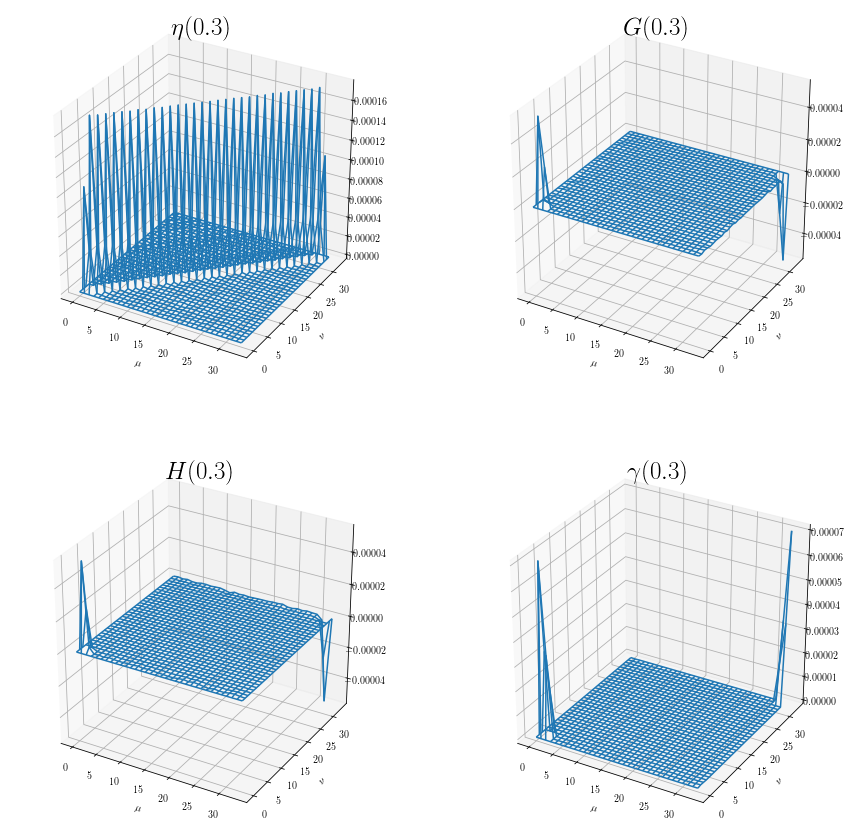

In [28]:
x = range(nNodes)
y = range(nNodes)

f  = plt.figure(figsize=(15,15))

X, Y = np.meshgrid(x, y)
ha = f.add_subplot(2,2,1, projection='3d')
ha.plot_wireframe(X, Y, Etat[:,:,step(tau)])
ha.set_title(r'$\eta(0.3)$',fontsize=25)
ha.set_xlabel(r'$\mu$')
ha.set_ylabel(r'$\nu$')

hb = f.add_subplot(2,2,2, projection='3d')
hb.plot_wireframe(X, Y, Gt[:,:,step(tau)].T)  #Python pinta la transpuesta. Buscar en stackoverflow
hb.set_title(r'$G(0.3)$',fontsize=25)
hb.set_xlabel(r'$\mu$')
hb.set_ylabel(r'$\nu$')

hc = f.add_subplot(2,2,3, projection='3d')
hc.plot_wireframe(X, Y, Ht[:,:,step(tau)].T)   #Python pinta la transpuesta. Buscar en stackoverflow
hc.set_title(r'$H(0.3)$',fontsize=25)
hc.set_xlabel(r'$\mu$')
hc.set_ylabel(r'$\nu$')

hd = f.add_subplot(2,2,4, projection='3d')
hd.plot_wireframe(X, Y, Gammat[:,:,step(tau)])
hd.set_title(r'$\gamma(0.3)$',fontsize=25)
hd.set_xlabel(r'$\mu$')
hd.set_ylabel(r'$\nu$')

plt.show()

### 4.2.2. Plot  $\eta_{\mu\nu}(t)$, $G_{\mu\nu}(t)$, $H_{\mu\nu}(t)$ and $\gamma_{\mu\nu}(t)$ 

# NOMENCLATURA

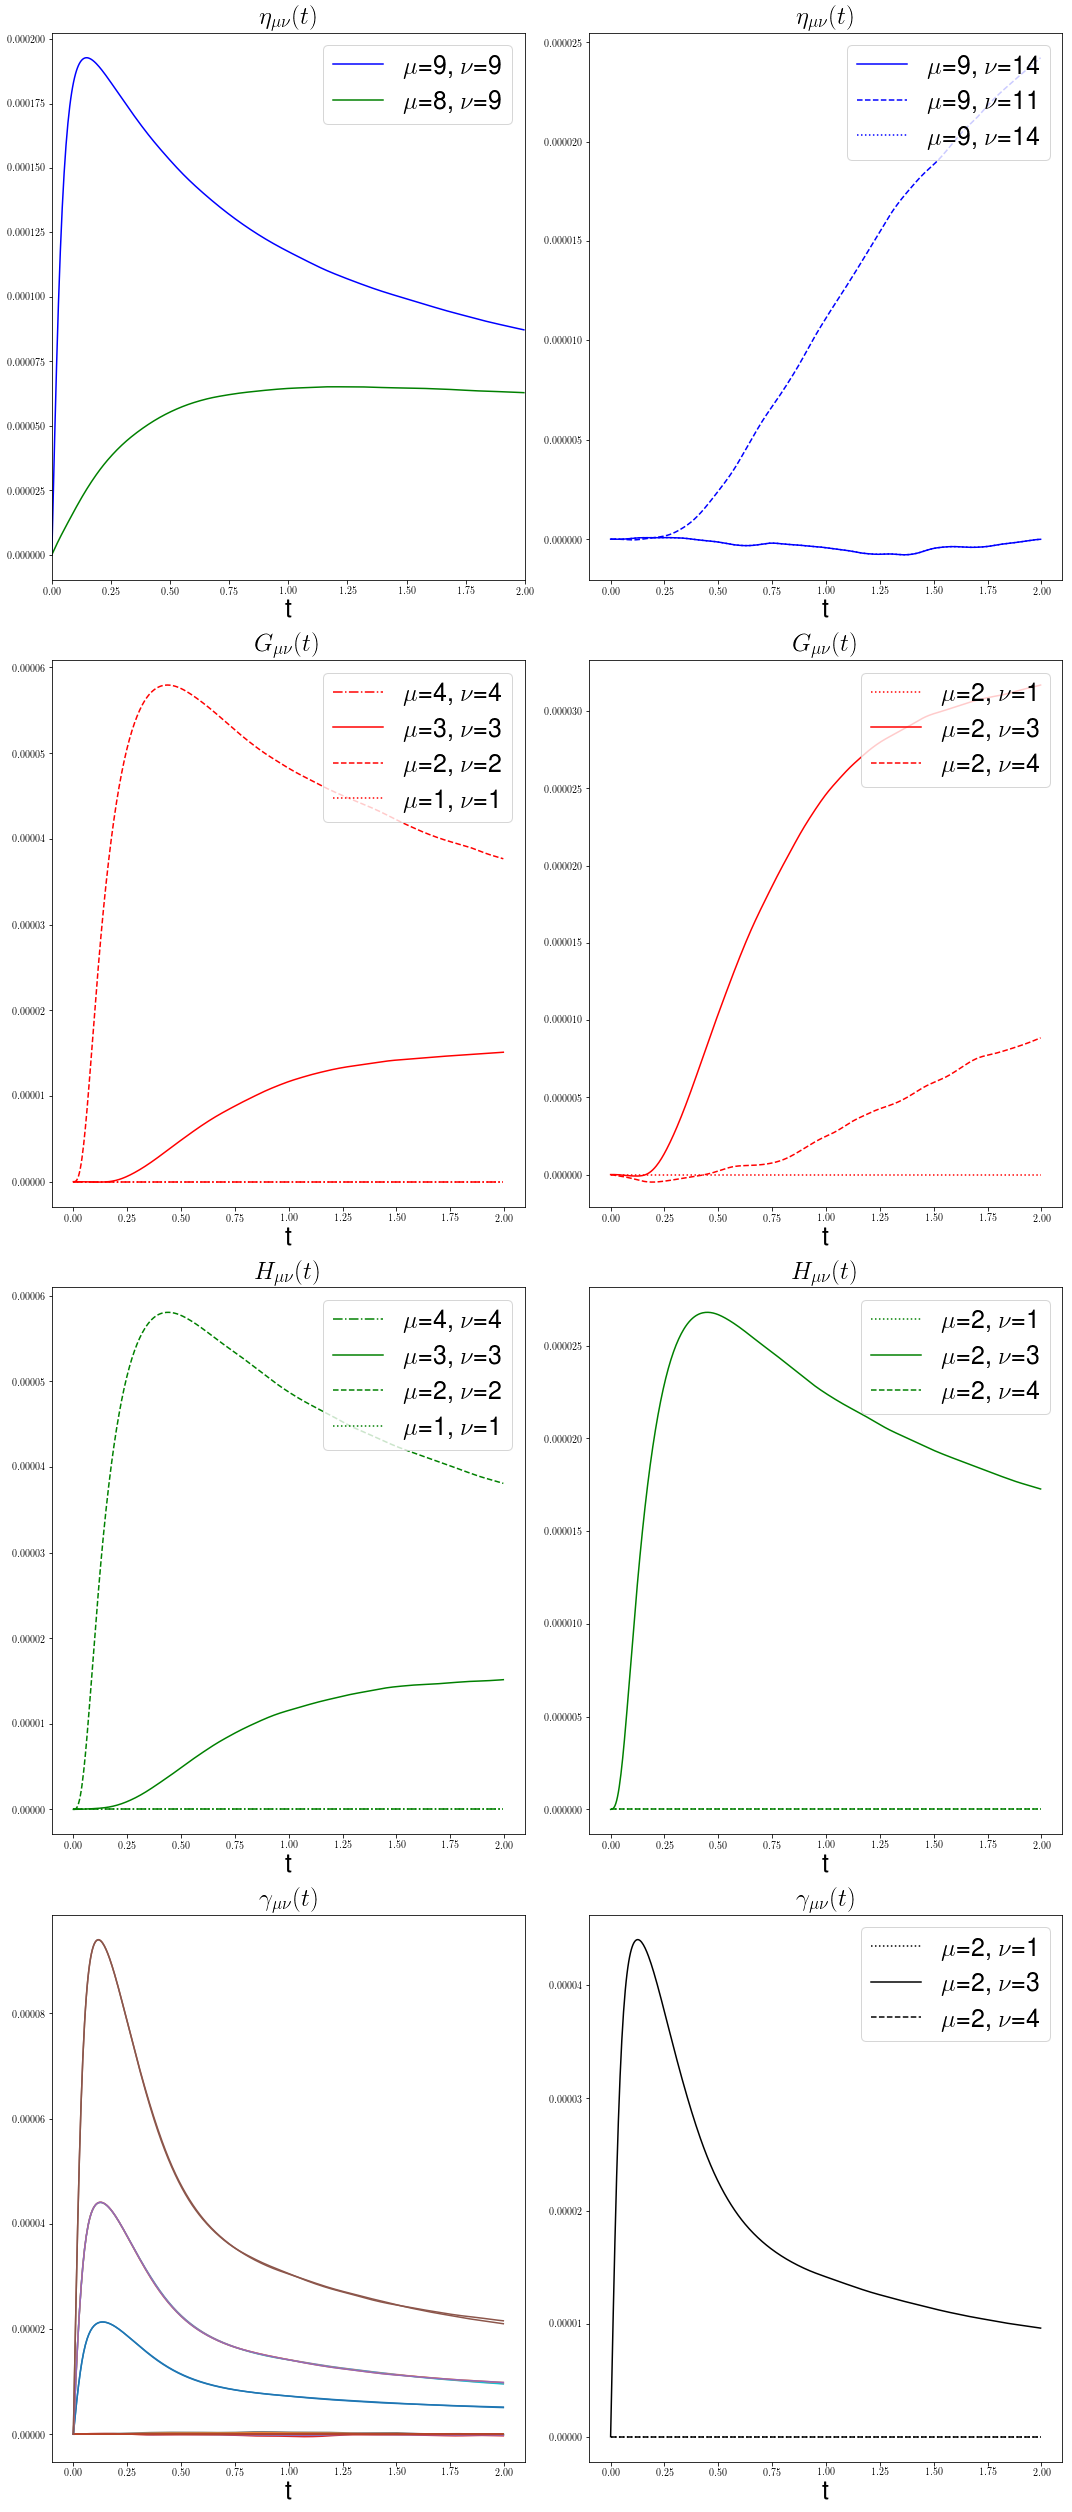

In [29]:
x = np.arange(0, nSteps * dt, dt)

plt.figure(1, figsize=(15,35))

plt.subplot(421)
#plt.plot(x, Etat[0,0,:], '-.b',  label=r'$\mu$=1, $\nu$=1')
plt.plot(x, Etat[8,8,:], 'b',  label=r'$\mu$=9, $\nu$=9')
plt.plot(x, Etat[7,8,:], 'g',  label=r'$\mu$=8, $\nu$=9')
#plt.plot(x, Etat[13,13,:], '--b', label=r'$\mu$=14, $\nu$=14')
plt.title(r'$\eta_{\mu\nu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)
plt.xlim(0,2)

plt.subplot(422)
plt.plot(x, Etat[8,13,:], 'b'  , label=r'$\mu$=9, $\nu$=14')
plt.plot(x, Etat[8,10,:], '--b',label=r'$\mu$=9, $\nu$=11')
plt.plot(x, Etat[8,13,:], ':b' ,label=r'$\mu$=9, $\nu$=14')
plt.title(r'$\eta_{\mu\nu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(423)
plt.plot(x, Gt[3,3,:], '-.r', label=r'$\mu$=4, $\nu$=4')
plt.plot(x, Gt[2,2,:], 'r', label=r'$\mu$=3, $\nu$=3')
plt.plot(x, Gt[1,1,:], '--r', label=r'$\mu$=2, $\nu$=2')
plt.plot(x, Gt[0,0,:], ':r', label=r'$\mu$=1, $\nu$=1')
plt.title(r'$G_{\mu\nu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(424)
plt.plot(x, Gt[1,0,:],':r', label=r'$\mu$=2, $\nu$=1')
plt.plot(x, Gt[1,2,:],'r', label=r'$\mu$=2, $\nu$=3')
plt.plot(x, Gt[1,3,:],'--r', label=r'$\mu$=2, $\nu$=4')
plt.title(r'$G_{\mu\nu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(425)
plt.plot(x, Ht[3,3,:], '-.g', label=r'$\mu$=4, $\nu$=4')
plt.plot(x, Ht[2,2,:],  'g',label=r'$\mu$=3, $\nu$=3')
plt.plot(x, Ht[1,1,:], '--g', label=r'$\mu$=2, $\nu$=2')
plt.plot(x, Ht[0,0,:], ':g', label=r'$\mu$=1, $\nu$=1')
plt.title(r'$H_{\mu\nu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(426)
plt.plot(x, Ht[1,0,:],':g', label=r'$\mu$=2, $\nu$=1')
plt.plot(x, Ht[1,2,:],'g', label=r'$\mu$=2, $\nu$=3')
plt.plot(x, Ht[1,3,:],'--g', label=r'$\mu$=2, $\nu$=4')
plt.title(r'$H_{\mu\nu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(427)
for i in range(nNodes):
    for j in range(nNodes):
        plt.plot(x, Gammat[i,j,:])
#plt.plot(x, Gammat[3,3,:], '-.k', label=r'$\mu$=4, $\nu$=4')
#plt.plot(x, Gammat[2,2,:], 'k' , label=r'$\mu$=3, $\nu$=3')
#plt.plot(x, Gammat[1,1,:], '--k', label=r'$\mu$=2, $\nu$=2')
#plt.plot(x, Gammat[0,0,:], ':k', label=r'$\mu$=1, $\nu$=1')
plt.title(r'$\gamma_{\mu\nu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.subplot(428)
plt.plot(x, Gammat[1,0,:],':k', label=r'$\mu$=2, $\nu$=1')
plt.plot(x, Gammat[1,2,:],'k', label=r'$\mu$=2, $\nu$=3')
plt.plot(x, Gammat[1,3,:],'--k', label=r'$\mu$=2, $\nu$=4')
plt.title(r'$\gamma_{\mu\nu}(t)$',fontsize=25)
plt.xlabel('t',fontsize=25)
plt.legend(loc='upper right',fontsize=25)

plt.tight_layout() #Improve spacing between subplots
plt.show()

## 4.4. Compute $M(t)$

$M(t)=F^T\cdot \eta(t)\cdot F+G(t)\cdot F+F^T\cdot H(t)+\gamma(t)$

In [30]:
Mt = np.zeros((nNodes, nNodes, nSteps))
for k in range(nSteps):
    Mt[:,:,k] = (F.T).dot(Etat[:,:,k]).dot(F) + Gt[:,:,k].dot(F) + (F.T).dot(Ht[:,:,k]) + Gammat[:,:,k]

## 4.5. Validate the theorem

We would like to obtain the transport kernels from the matrix of correlations C(t). For this reason we need to validate the following theorem 

$\dot{C}(t) = -k_B·T·M(t) = -k_B·T·[F^T\eta(t)F+G(t)F+F^TH(t)+\gamma(t)]$ 

where the transport kernels are calculated with the Green-Kubo formula.

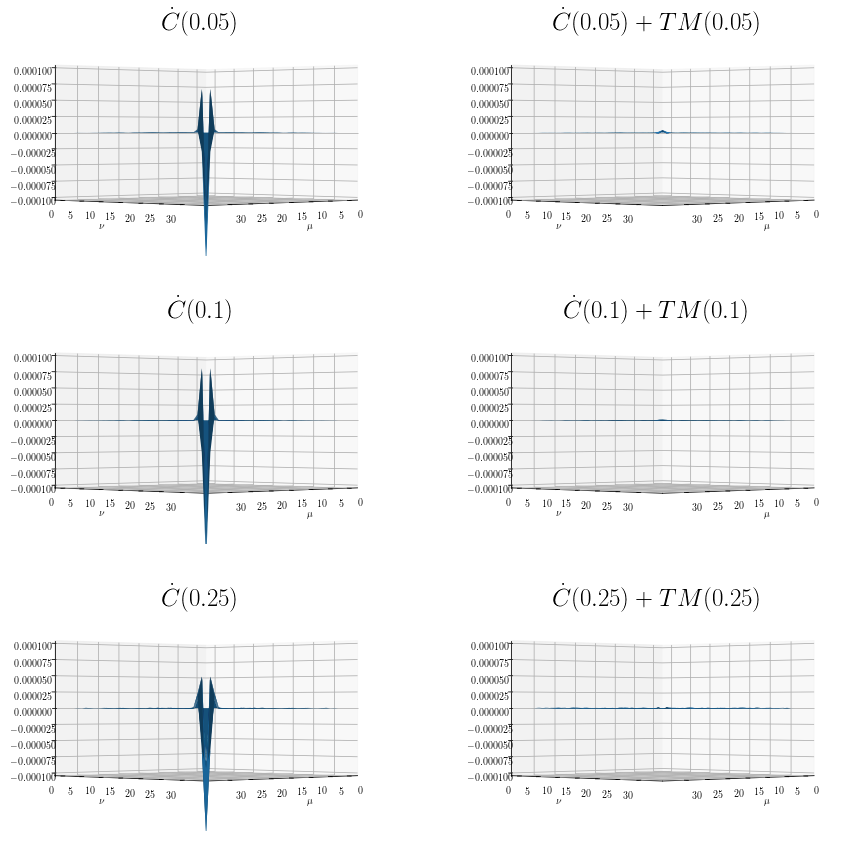

In [31]:
checkTheoremt = (CtDev[:,:,:] + Temp * Mt)

x = range(nNodes)
y = range(nNodes)

f  = plt.figure(figsize=(15,15))

X, Y = np.meshgrid(x, y)
ha = f.add_subplot(3,2,1, projection='3d')
ha.plot_surface(X, Y, CtDev[:,:,step(0.05)])
ha.set_title(r'$\dot{C}(0.05)$',fontsize=25)
ha.set_xlabel(r'$\mu$')
ha.set_ylabel(r'$\nu$')
ha.set_zlim(-1e-4,1e-4)
ha.view_init(0, 45)

hb = f.add_subplot(3,2,3, projection='3d')
hb.plot_surface(X, Y, CtDev[:,:,step(0.1)])
hb.set_title(r'$\dot{C}(0.1)$',fontsize=25)
hb.set_xlabel(r'$\mu$')
hb.set_ylabel(r'$\nu$')
hb.set_zlim(-1e-4,1e-4)
hb.view_init(0, 45)

hc = f.add_subplot(3,2,5, projection='3d')
hc.plot_surface(X, Y, CtDev[:,:,step(tau)])
hc.set_title(r'$\dot{C}(0.25)$',fontsize=25)
hc.set_xlabel(r'$\mu$')
hc.set_ylabel(r'$\nu$')
hc.set_zlim(-1e-4,1e-4)
hc.view_init(0, 45)

hd = f.add_subplot(3,2,2, projection='3d')
hd.plot_surface(X, Y, checkTheoremt[:,:,step(0.05)])
hd.set_title(r'$\dot{C}(0.05)+ TM(0.05)$',fontsize=25)
hd.set_xlabel(r'$\mu$')
hd.set_ylabel(r'$\nu$')
hd.set_zlim(-1e-4,1e-4)
hd.view_init(0, 45)

he = f.add_subplot(3,2,4, projection='3d')
he.plot_surface(X, Y, checkTheoremt[:,:,step(0.1)])
he.set_title(r'$\dot{C}(0.1)+ TM(0.1)$',fontsize=25)
he.set_xlabel(r'$\mu$')
he.set_ylabel(r'$\nu$')
he.set_zlim(-1e-4,1e-4)
he.view_init(0, 45)

hf = f.add_subplot(3,2,6, projection='3d')
hf.plot_surface(X, Y, checkTheoremt[:,:,step(tau)])
hf.set_title(r'$\dot{C}(0.25)+ TM(0.25)$',fontsize=25)
hf.set_xlabel(r'$\mu$')
hf.set_ylabel(r'$\nu$')
hf.set_zlim(-1e-4,1e-4)
hf.view_init(0, 45)

plt.show()

## 4.6. Compute $\tilde{\eta}(t)$, $\tilde{G}(t)$, $\tilde{H}(t)$, $\tilde{\gamma}(t)$ and $\tilde{\Gamma}(t)$

The basis used is E(t) (the basis of eigenvectors of $C(t)$ calculated in each time step)

In [32]:
EtatRec      = np.zeros((nNodes, nNodes, nSteps))
GtRec        = np.zeros((nNodes, nNodes, nSteps))
HtRec        = np.zeros((nNodes, nNodes, nSteps))
GammatRec    = np.zeros((nNodes, nNodes, nSteps))
BtRec        = np.zeros((nNodes, nNodes, nSteps))
FtRec        = np.zeros((nNodes, nNodes, nSteps))
BEtatFRec    = np.zeros((nNodes, nNodes, nSteps))
GAMMAtRec    = np.zeros((nNodes, nNodes, nSteps))
checkThRec   = np.zeros((nNodes, nNodes, nSteps))

for k in range(nSteps):
    #Compute and sort eigenvalues and eigenvectors of C(t)
    w, v      = LA.eig((Ct[:,:,k]))
    idx       = w.argsort()[::-1]   
    w         = w[idx]
    v         = v[:,idx]
    #Compute transprt coeff. in the reciprocal space
    EtatRec[:,:,k]      = inv(v).dot(Etat[:,:,k]).dot(v)
    GtRec[:,:,k]        = inv(v).dot(Gt[:,:,k]).dot(v)
    HtRec[:,:,k]        = inv(v).dot(Ht[:,:,k]).dot(v)
    GammatRec[:,:,k]    = inv(v).dot(Gammat[:,:,k]).dot(v)
    GAMMAtRec[:,:,k]    = inv(v).dot(GAMMAt[:,:,k]).dot(v)
    BtRec[:,:,k]        = inv(v).dot(F.T).dot(v)
    FtRec[:,:,k]        = inv(v).dot(F).dot(v)

### 4.6.1. Plot $\tilde{\eta}(t)$, $\tilde{G}(t)$, $\tilde{H}(t)$, $\tilde{\gamma}(t)$ and $\tilde{\Gamma}(t)$

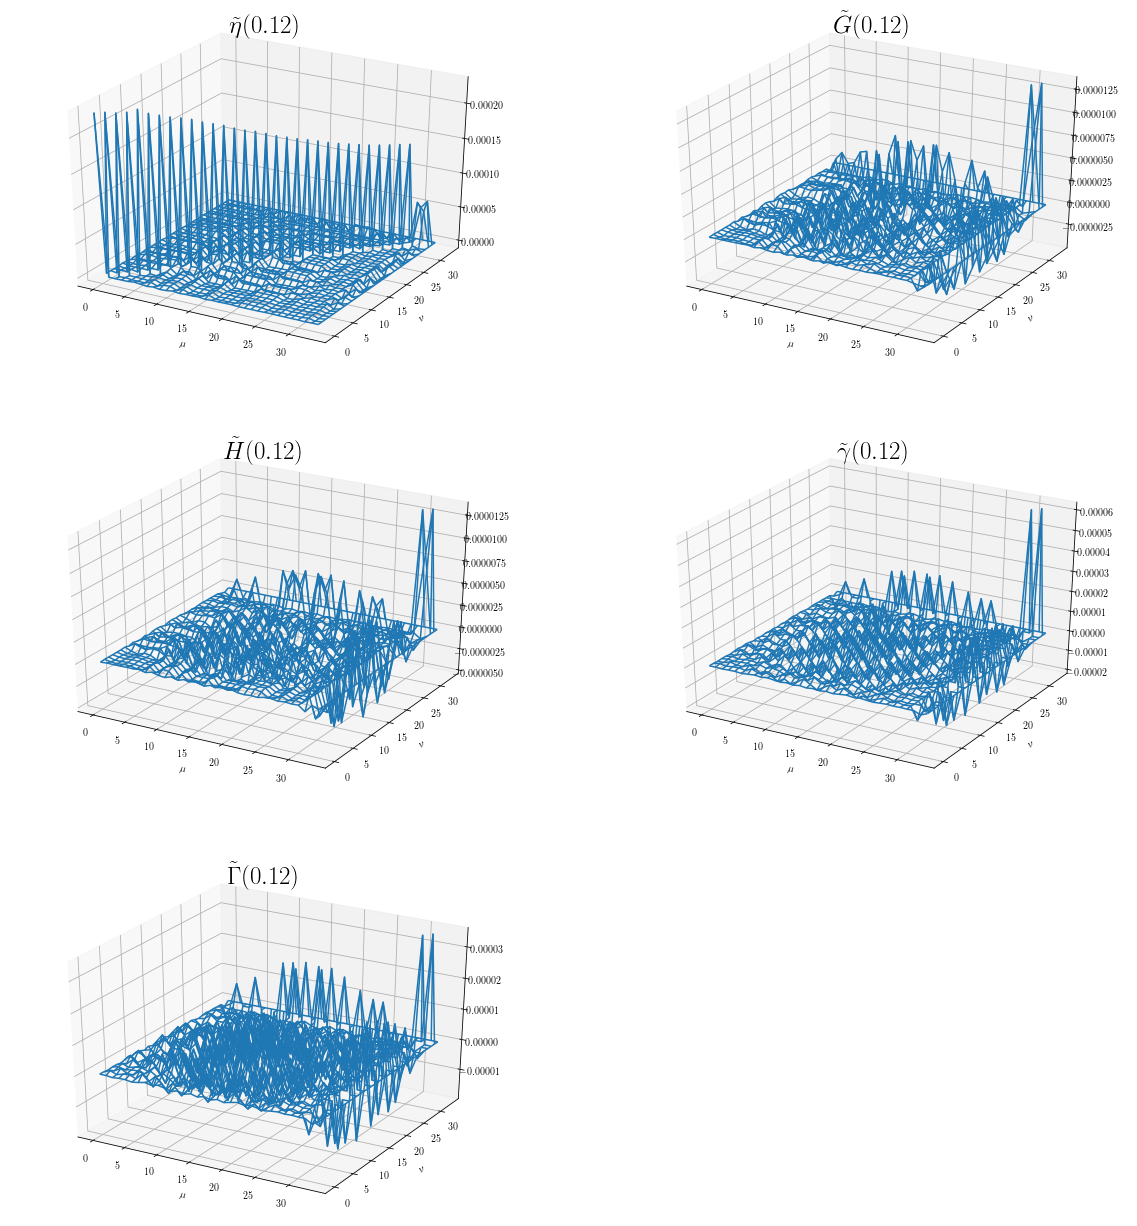

In [33]:
x    = range(nNodes)
y    = range(nNodes)
X, Y = np.meshgrid(x, y)

f  = plt.figure(figsize=(20,30))

ha = f.add_subplot(4,2,1, projection='3d')
ha.plot_wireframe(X, Y, EtatRec[:,:,step(0.12)])
ha.set_title(r'$\tilde{\eta}(0.12)$',fontsize=25)
ha.set_xlabel(r'$\mu$')
ha.set_ylabel(r'$\nu$')

ha = f.add_subplot(4,2,2, projection='3d')
ha.plot_wireframe(X, Y, GtRec[:,:,step(0.12)])
ha.set_title(r'$\tilde{G}(0.12)$',fontsize=25)
ha.set_xlabel(r'$\mu$')
ha.set_ylabel(r'$\nu$')

ha = f.add_subplot(4,2,3, projection='3d')
ha.plot_wireframe(X, Y, HtRec[:,:,step(0.12)])
ha.set_title(r'$\tilde{H}(0.12)$',fontsize=25)
ha.set_xlabel(r'$\mu$')
ha.set_ylabel(r'$\nu$')

ha = f.add_subplot(4,2,4, projection='3d')
ha.plot_wireframe(X, Y, GammatRec[:,:,step(0.12)])
ha.set_title(r'$\tilde{\gamma}(0.12)$',fontsize=25)
ha.set_xlabel(r'$\mu$')
ha.set_ylabel(r'$\nu$')

ha = f.add_subplot(4,2,5, projection='3d')
ha.plot_wireframe(X, Y, GAMMAtRec[:,:,step(0.12)])
ha.set_title(r'$\tilde{\Gamma}(0.12)$',fontsize=25)
ha.set_xlabel(r'$\mu$')
ha.set_ylabel(r'$\nu$')

plt.show()

### Plot $\tilde{\eta}_{\mu\nu}(t)$, $\tilde{G}_{\mu\nu}(t)$, $\tilde{H}_{\mu\nu}(t)$, $\tilde{\gamma}_{\mu\nu}(t)$ and $\tilde{\Gamma}_{\mu\nu}(t)$

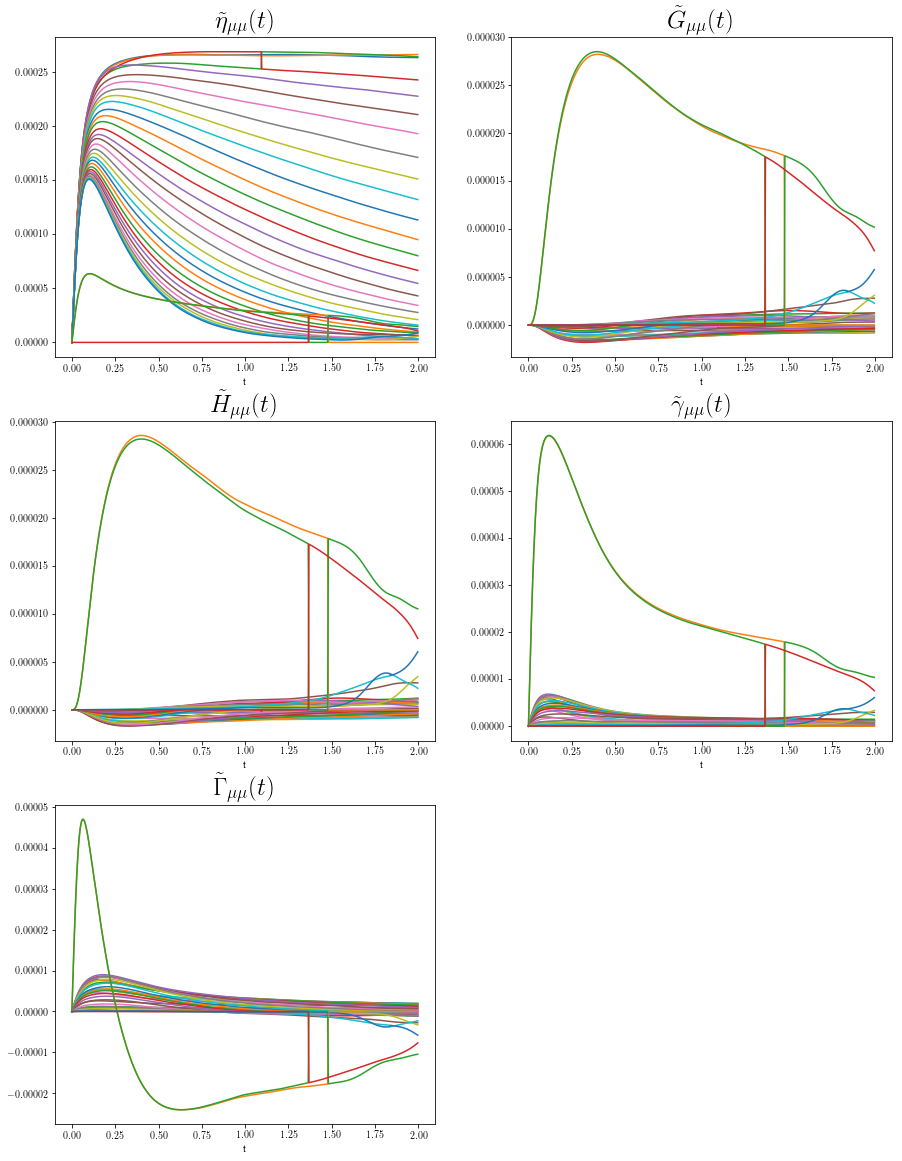

In [34]:
x = np.arange(0, nSteps * dt, dt)
f  = plt.figure(figsize=(15,20))

plt.subplot(321)
for i in np.arange(nNodes):
    plt.plot(x, EtatRec[i,i,:])
plt.title(r'$\tilde{\eta}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t')
#plt.xlim(0,2)
#plt.ylim(-1e-5,3e-3)

plt.subplot(322)
for i in range(nNodes):
    plt.plot(x, GtRec[i,i,:])
plt.title(r'$\tilde{G}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t')
#plt.xlim(0,2)
#plt.ylim(-1e-5,1e-5)

plt.subplot(323)
for i in range(nNodes):
    plt.plot(x, HtRec[i,i,:])
plt.title(r'$\tilde{H}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t')
#plt.xlim(0,2)
#plt.ylim(-1e-5,1e-5)

plt.subplot(324)
for i in range(nNodes):
    plt.plot(x, GammatRec[i,i,:])
plt.title(r'$\tilde{\gamma}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t')
#plt.xlim(0,2)
#plt.ylim(-3e-5,3e-4)

plt.subplot(325)
for i in range(nNodes):
    plt.plot(x, GAMMAtRec[i,i,:])
plt.title(r'$\tilde{\Gamma}_{\mu\mu}(t)$',fontsize=25)
plt.xlabel('t')
#plt.xlim(0,2)
#plt.ylim(-3e-5,3e-4)

plt.show()

## 4.7. Validate the theorem in the reciprocal space
$\tilde{\dot{C}}(t) = -k_B·T·\tilde{M}(t) = -k_B·T·[\tilde{F^T}·\tilde{\eta}(t)·\tilde{F} + \tilde{G}(t)·\tilde{F} + \tilde{F}·\tilde{H}(t) + \tilde{\gamma}(t)]$ 

In [35]:
checkThRec   = np.zeros((nNodes, nNodes, nSteps))
for k in range(nSteps):
    checkThRec[:,:,k]   = - Temp * ((BtRec[:,:,k]).dot(EtatRec[:,:,k]).dot(FtRec[:,:,k]) \
                                    + GAMMAtRec[:,:,k])

$\tilde{\dot{C}}(t)\tilde{C}^{-1}(t)  = -\tilde{\Lambda} =-k_B·T·\tilde{B}·\tilde{\eta}(t)·\tilde{F}·\tilde{C}^{-1}(t) - k_B·T·\tilde{\Gamma}(t)·\tilde{C}^{-1}(t) = - A - H$

If $\Lambda(t)$ has a plateau both A and H should have a plateau. 

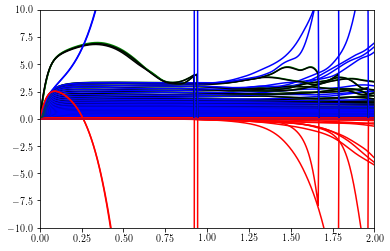

In [36]:
A   = np.zeros((nNodes, nNodes, nSteps))
H   = np.zeros((nNodes, nNodes, nSteps))
for k in range(nSteps):
    A[:,:,k] = Temp * ((BtRec[:,:,k]).dot(EtatRec[:,:,k]).dot(FtRec[:,:,k]).dot(CtInvRec[:,:,k]))
    H[:,:,k] = Temp * GAMMAtRec[:,:,k].dot(CtInvRec[:,:,k])

x = np.arange(0, nSteps * dt, dt)
for i in range(nNodes):
#for i in np.arange(16,17,1):
    plt.plot(x, LambdatRec[i,i,:], 'g')
    plt.plot(x, A[i,i,:] + H[i,i,:], 'k')
    plt.plot(x,A[i,i,:], 'b')
    plt.plot(x,H[i,i,:], 'r')
plt.xlim(0,2)
plt.ylim(-10,10)
plt.show()

hay dos modos que explotan pero se compensan para dar la $\Lambda$ con plateau. Esto parece indicar que hay información intercambiada entre el tensor de tensiones y la fuerza. 
A la vista de estos resultados definimos de nuevo el tensor de tensiones de tal manera que tenga en cuenta la pared. Tendremos una viscosidad que ve la pared.

# 5. NON-LOCAL KERNELS FROM CORRECTED GREEN-KUBO

If the Markovian approximation is correct for the selected set of CG variables, we should have from

$\dot{C}(t) = -k_B·T·M(t) = -k_B·T·[F^T·\eta(t)·F + G(t)·F + F^T·H(t) + \gamma(t)]=-k_B·T·[F^T·\eta(t)·F+\Gamma] $ 

the following expression

$\dot{C}(t) = -k_B·T·M^*·C^{-1}(0)·C(t)
            = -k_B·T·[F^T·\eta^*·F - G^*·F - F^T·H^* + \gamma^*]·C^{-1}(0)·C(t)
            = -k_B·T·[F^T·\eta^*·F+\Gamma^*(t)]·C^{-1}(0)·C(t)$ 

Then $M^*=F^T·\eta^*·F + G^*·F + F^T·H^* + \gamma^*  = F^T·\eta^*·F + \Gamma^*$ 

**The transport kernels obtained should have a *plateau***.

There is a correspondence between the terms 

$F^T·\eta(t)·F =F^T·\eta^*F·c(t) \to \eta^*=\eta(t)·F·c^{-1}(t)·({F})^{-1}$ 

$G(t)·F = G^*·F·c(t)             \to G^*=G(t)·F·c^{-1}(t)·({F})^{-1}$

$F^T·H(t) = F^T·H^*·c(t)         \to H^*=H(t)·c^{-1}(t)$

$\gamma(t) = \gamma^*·c(t)       \to \gamma^*=\gamma(t)·c^{-1}(t)$

where we have introduced $c(t) = C^{-1}(0)·C(t)$.

If $c^{-1}(t)$ and $F$ commute we have

$\eta^*=\eta(t)·c^{-1}(t)$

$G^*=G(t)·c^{-1}(t)$

$H^*=H(t)·c^{-1}(t)$

$\gamma^*=\gamma(t)·c^{-1}(t)$

## 5.1. Do $c^{-1}(t)$ and $F$ commute?

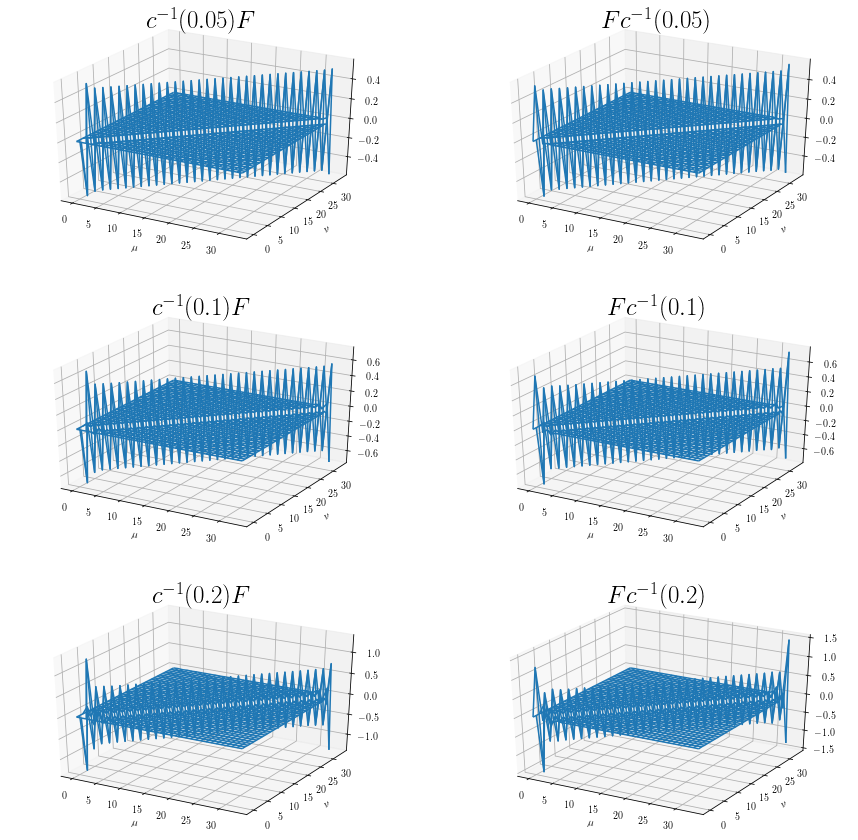

In [37]:
x = range(nNodes)
y = range(nNodes)

f  = plt.figure(figsize=(15,15))

X, Y = np.meshgrid(x, y)
ha = f.add_subplot(3,2,1, projection='3d')
ha.plot_wireframe(X, Y, CtNormInv[:,:,step(0.05)].dot(F))
ha.set_title(r'$c^{-1}(0.05)F$',fontsize=25)
ha.set_xlabel(r'$\mu$')
ha.set_ylabel(r'$\nu$')
#ha.view_init(0, 45)

hb = f.add_subplot(3,2,3, projection='3d')
hb.plot_wireframe(X, Y, CtNormInv[:,:,step(0.1)].dot(F))
hb.set_title(r'$c^{-1}(0.1)F$',fontsize=25)
hb.set_xlabel(r'$\mu$')
hb.set_ylabel(r'$\nu$')
#hb.view_init(0, 45)

hc = f.add_subplot(3,2,5, projection='3d')
hc.plot_wireframe(X, Y, CtNormInv[:,:,step(0.2)].dot(F))
hc.set_title(r'$c^{-1}(0.2)F$',fontsize=25)
hc.set_xlabel(r'$\mu$')
hc.set_ylabel(r'$\nu$')
#hc.view_init(0, 45)

hd = f.add_subplot(3,2,2, projection='3d')
hd.plot_wireframe(X, Y, F.dot(CtNormInv[:,:,step(0.05)]))
hd.set_title(r'$Fc^{-1}(0.05)$',fontsize=25)
hd.set_xlabel(r'$\mu$')
hd.set_ylabel(r'$\nu$')
#hd.view_init(0, 45)

he = f.add_subplot(3,2,4, projection='3d')
he.plot_wireframe(X, Y, F.dot(CtNormInv[:,:,step(0.1)]))
he.set_title(r'$Fc^{-1}(0.1)$',fontsize=25)
he.set_xlabel(r'$\mu$')
he.set_ylabel(r'$\nu$')
#he.view_init(0, 45)

hf = f.add_subplot(3,2,6, projection='3d')
hf.plot_wireframe(X, Y, F.dot(CtNormInv[:,:,step(0.2)]))
hf.set_title(r'$Fc^{-1}(0.2)$',fontsize=25)
hf.set_xlabel(r'$\mu$')
hf.set_ylabel(r'$\nu$')
#hf.view_init(0, 45)

plt.show()

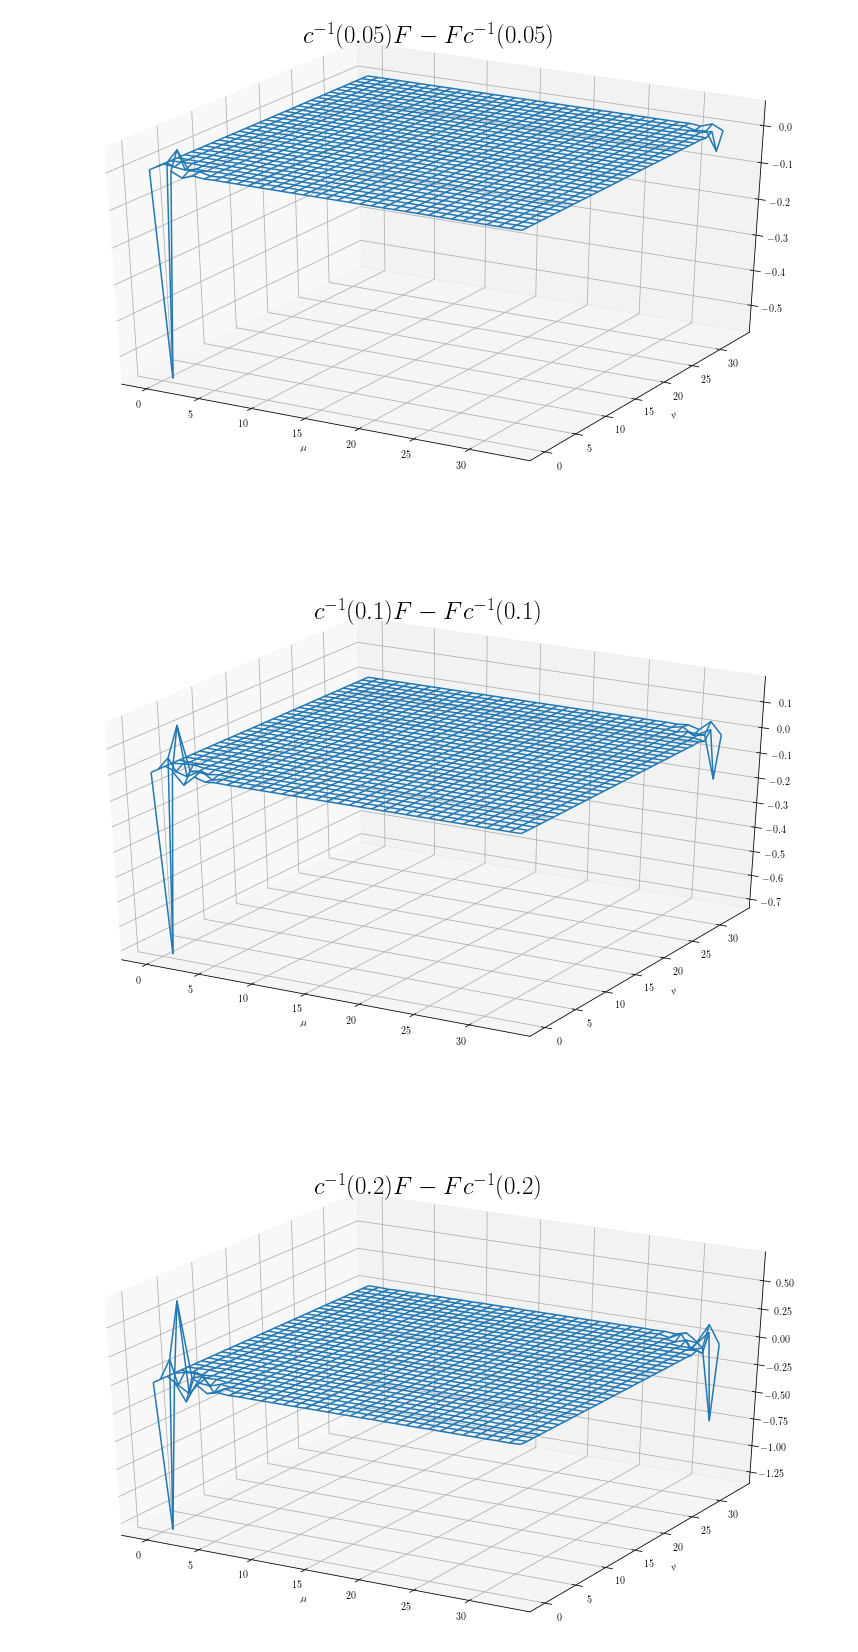

In [38]:
x = range(nNodes)
y = range(nNodes)

f  = plt.figure(figsize=(15,30))

X, Y = np.meshgrid(x, y)
ha = f.add_subplot(3,1,1, projection='3d')
ha.plot_wireframe(X, Y, CtNormInv[:,:,step(0.05)].dot(F) - F.dot(CtNormInv[:,:,step(0.05)]))
ha.set_title(r'$c^{-1}(0.05)F-Fc^{-1}(0.05)$',fontsize=25)
ha.set_xlabel(r'$\mu$')
ha.set_ylabel(r'$\nu$')
#ha.view_init(0, 45)

hb = f.add_subplot(3,1,2, projection='3d')
hb.plot_wireframe(X, Y, CtNormInv[:,:,step(0.1)].dot(F) - F.dot(CtNormInv[:,:,step(0.1)]))
hb.set_title(r'$c^{-1}(0.1)F-Fc^{-1}(0.1)$',fontsize=25)
hb.set_xlabel(r'$\mu$')
hb.set_ylabel(r'$\nu$')
#hb.view_init(0, 45)

hc = f.add_subplot(3,1,3, projection='3d')
hc.plot_wireframe(X, Y, CtNormInv[:,:,step(0.2)].dot(F)-F.dot(CtNormInv[:,:,step(0.2)]))
hc.set_title(r'$c^{-1}(0.2)F-Fc^{-1}(0.2)$',fontsize=25)
hc.set_xlabel(r'$\mu$')
hc.set_ylabel(r'$\nu$')
#hc.view_init(0, 45)

plt.show()

The matrices are pretty similar but near the walls are not equal. $c^{-1}(t)$ and $F$ do not commute. Therefore, **we can NOT** try to obtain the non-local kernels from the following expressions

$\eta^*=\eta(t)·c^{-1}(t)$

$G^*=G(t)·c^{-1}(t)$

$H^*=H(t)·c^{-1}(t)$

$\gamma^*=\gamma(t)·c^{-1}(t)$

# 6. Compute transport coefficients ($c^{-1}(t)$ and $F$ do not commute)
$\eta = \eta(\tau)$

$G = G(\tau)$

$H = H(\tau)$

$\gamma = \gamma(\tau)$

----------

$\eta^*=\eta·F·c^{-1}(\tau)·{F}^{-1}$ 


$G^*=G·F·c^{-1}(\tau)·{F}^{-1}$

$H^*=H\cdot c^{-1}(\tau)$

$\gamma^*=\gamma\cdot c^{-1}(\tau)$

In [39]:
Eta   = Etat[:,:,step(tau)]
G     = Gt[:,:,step(tau)]
H     = Ht[:,:,step(tau)]
Gamma = Gammat[:,:,step(tau)]

In [40]:
EtaStar   = Eta.dot(F).dot(CtNormInv[:,:,step(tau)]).dot(FInv)
GStar     = G.dot(F).dot(CtNormInv[:,:,step(tau)]).dot(FInv)
HStar     = H.dot(CtNormInv[:,:,step(tau)])
GammaStar = Gamma.dot(CtNormInv[:,:,step(tau)])

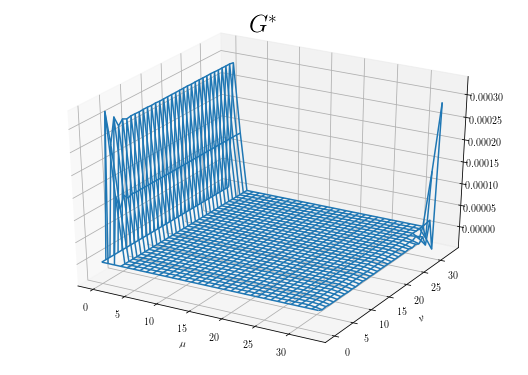

In [41]:
x    = range(nNodes)
y    = range(nNodes)
X, Y = np.meshgrid(x, y)

f  = plt.figure(figsize=(20,30))

ha = f.add_subplot(4,2,1, projection='3d')
ha.plot_wireframe(X, Y, GStar.T)
ha.set_title(r'$G^*$',fontsize=25)
ha.set_xlabel(r'$\mu$')
ha.set_ylabel(r'$\nu$')
plt.show()

# 7. $C^{pred}(t)$ using transport coefficients

## 7.1. Compute $M^*$, $M_2^*$, $\Lambda^*$ and $\Lambda_2^*$ 

$M^*=M(\tau)c^{-1}(\tau)$

$M_2^*=M(\tau)c^{-1}(0) = M(\tau) $

$\Lambda^*=T\cdot M^*\cdot C^{-1}(0)$

$\Lambda_2^*=T\cdot M_2^*\cdot C^{-1}(0)$

In [42]:
MStar           = Mt[:,:,step(tau)].dot(CtNormInv[:,:,step(tau)])
MStar2          = Mt[:,:,step(tau)]
LambdaStar      = Temp * MStar.dot(CtInv[:,:,step(0)])
LambdaStar2     = Temp * MStar2.dot(CtInv[:,:,step(0)])
CtPredictCoeff  = np.zeros((nNodes, nNodes, nSteps))
CtPredictCoeff2 = np.zeros((nNodes, nNodes, nSteps))
for k in range(nSteps):
    t = k * dt
    CtPredictCoeff[:,:,k]  = expm(- LambdaStar  * (t - tau)).dot(Ct[:,:,step(tau)])
    CtPredictCoeff2[:,:,k] = expm(- LambdaStar2 * (t - tau)).dot(Ct[:,:,step(tau)])

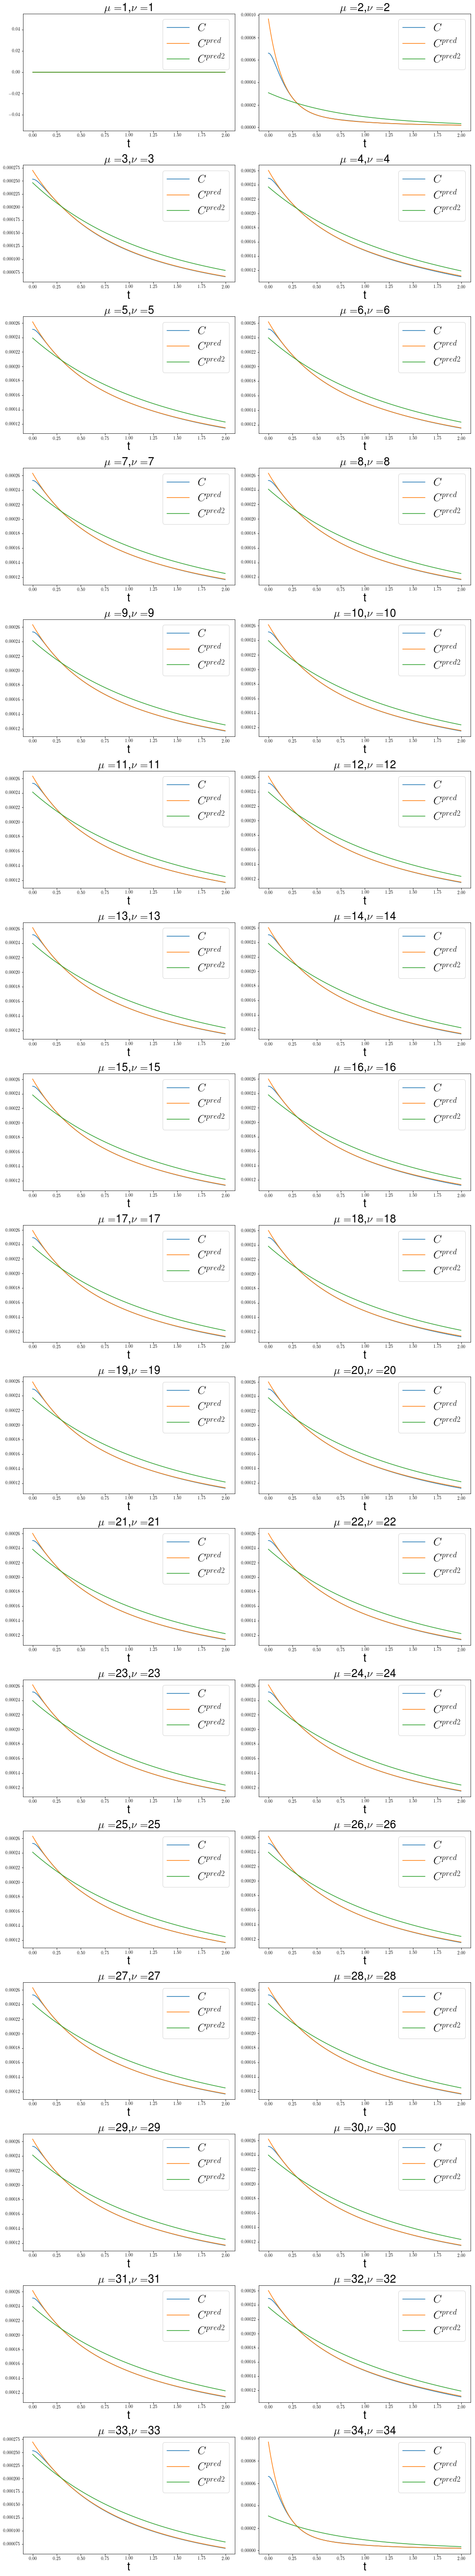

In [282]:
x = np.arange(0, nSteps * dt, dt)
plt.figure(1, figsize=(15,85))

nColumns = 2
nLines = nNodes / 2 + 1

for i in range(nNodes):
    plt.subplot(nLines,nColumns,i+1)
    plt.plot(x, Ct[i,i,:], label='$C$')
    plt.plot(x, CtPredictCoeff[i,i,:], label=r'$C^{pred}$')
    plt.plot(x, CtPredictCoeff2[i,i,:],label=r'$C^{pred2}$')
    plt.title(r'$\mu=$'+str(i+1)+r',$\nu=$'+str(i+1),fontsize=25)
    plt.xlabel('t',fontsize=25)
    plt.legend(loc='upper right',fontsize=25)
plt.tight_layout() #Improve spacing between subplots
plt.show()

# 8. Averages gx(t). ¡CUIDADO. nSteps del tensor y Fx son 500, mientras que para el plugFlow 7500!

In [44]:
gxtv05 = np.loadtxt('gx-avg-v05-x2Box.dat')
gxt = gxtv05
nStepsPlugFlow = np.shape(gxt)[0]
##Increase stat
#gxt = np.zeros((nSteps, nNodes))
#for k in range(nSteps):
#    gxt[k,1:17] = 0.5 * (gxtv05[k,1:17] + np.flip(gxtv05[k,18:], axis=0))
#    gxt[k,18:]  = np.flip(0.5 * (gxtv05[k,1:17] + np.flip(gxtv05[k,18:], axis=0)), axis=0)

## 8.1. Predictions $g^x(t)$

In [48]:
gxtPredict  = np.zeros((nStepsPlugFlow, nNodes))
gxtPredictGK = np.zeros((nStepsPlugFlow, nNodes))

for k in range(nStepsPlugFlow):
    t = k * dt
    expLambda = expm(- Lambdat[:,:,step(tau)] * (t-tau))
    expLambda[0,0] = 0   #hacemos 0 la componente 0,0 de la exponencial de lambda
    gxtPredict[k,:]   = expLambda.dot(gxt[step(tau),:])
    
    expLambdaStar = expm(- LambdaStar * (t-tau))
    expLambdaStar[0,0] = 0  #hacemos 0 la componente 0,0 de la exponencial de lambda
    gxtPredictGK[k,:] = expLambdaStar.dot(gxt[step(tau),:])
    
    #gxtPredict[k,:]  = expm(- Lambdat[:,:,step(tau)] * (t-tau)).dot(gxt[step(tau),:])
    #gxtPredictGK[k,:] = expm(- LambdaStar  * (t-tau)).dot(gxt[step(tau),:])

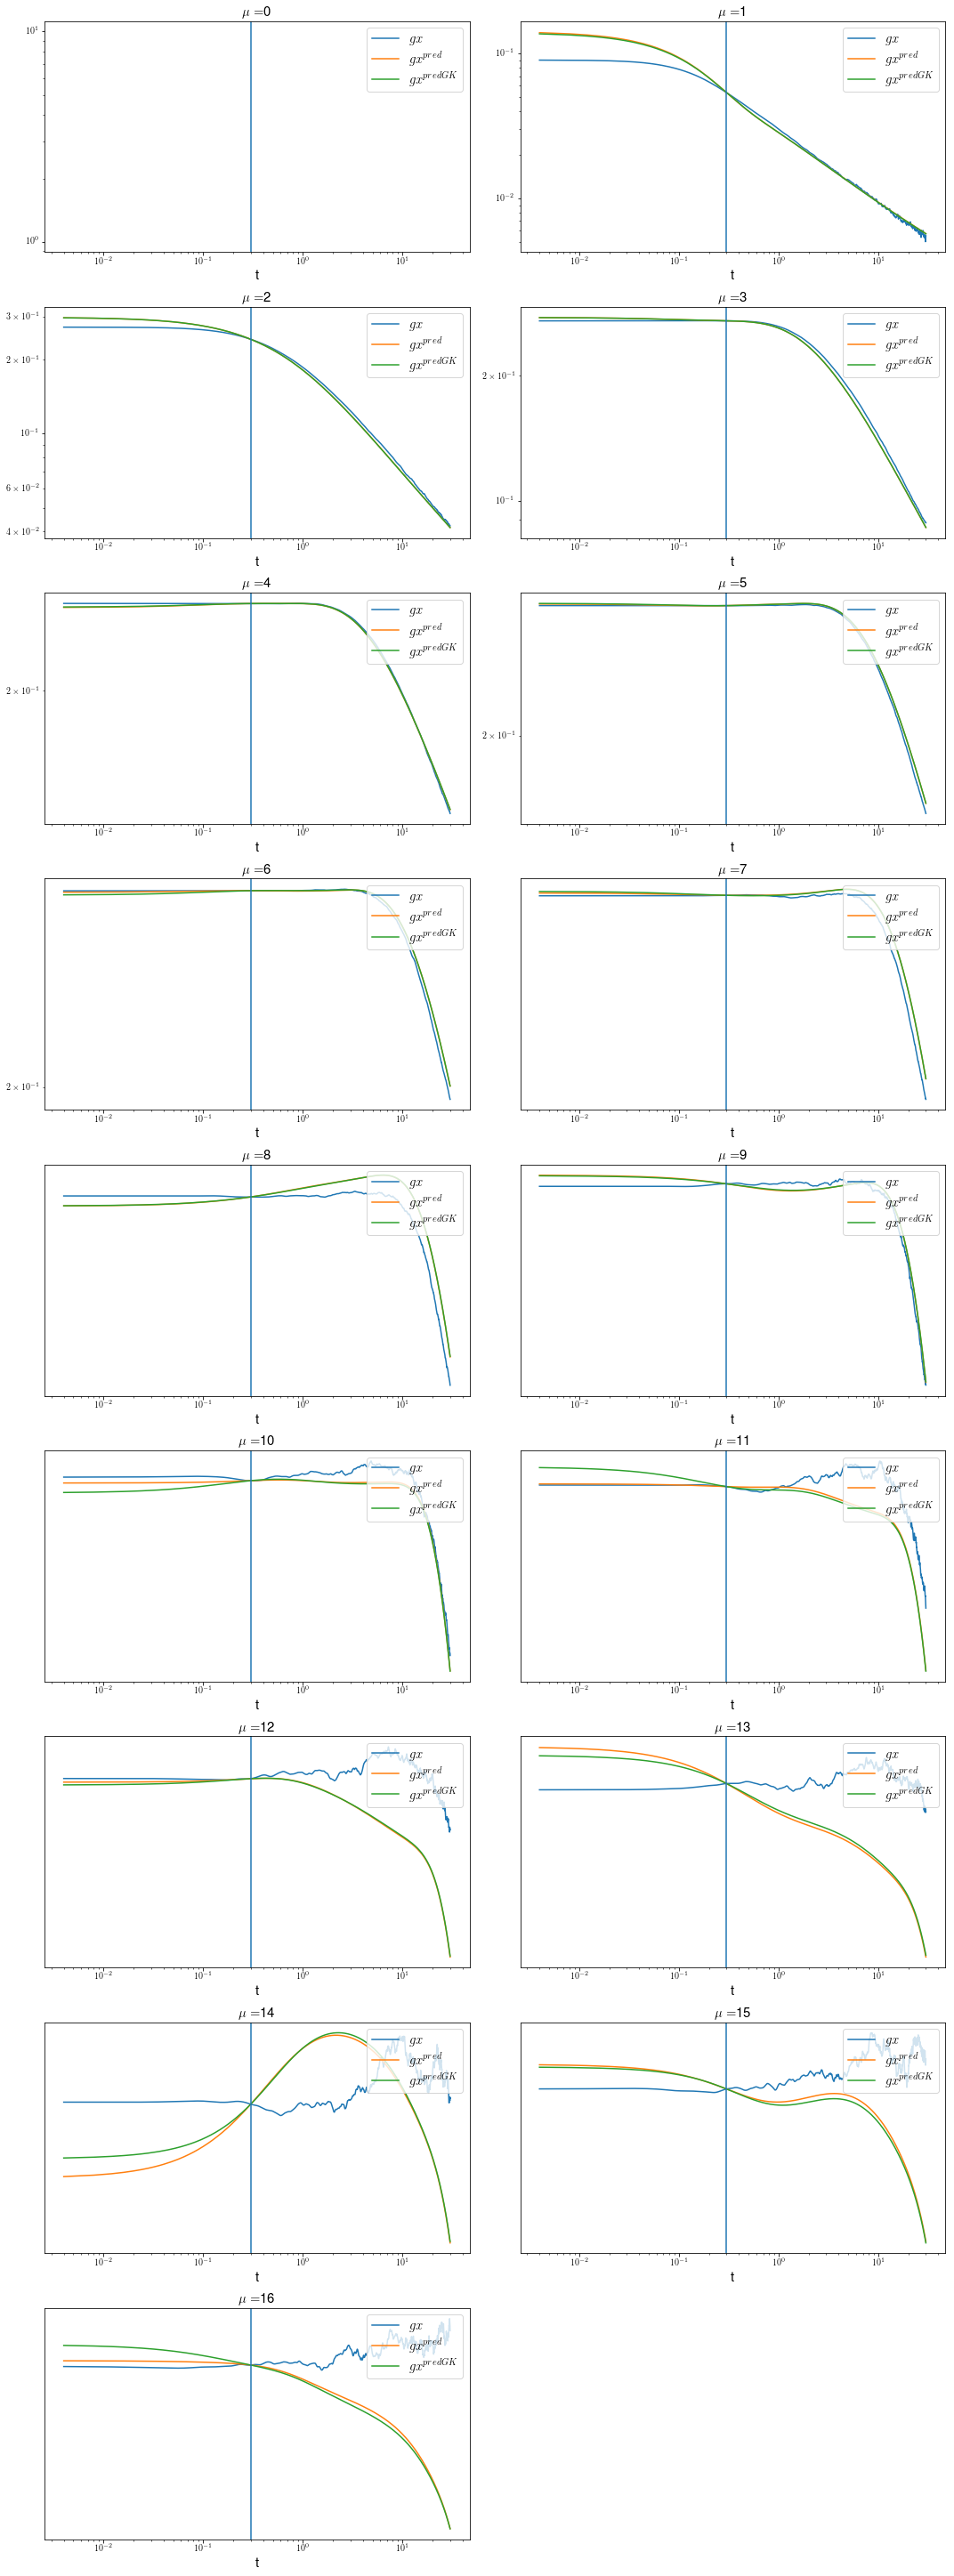

In [49]:
x = np.arange(0, nStepsPlugFlow * dt, dt)
plt.figure(1, figsize=(15,80))

nColumns = 2
nLines = nNodes / 2 + 1

for i in range(nNodes/2):
    plt.subplot(nLines,nColumns,i+1)
    plt.loglog(x, gxt[:,i], label='$gx$')
    plt.loglog(x, gxtPredict[:,i], label=r'$gx^{pred}$')
    plt.loglog(x, gxtPredictGK[:,i], label=r'$gx^{predGK}$')
    plt.axvline(x=tau)
    #plt.xlim(5,8)
    #plt.ylim(1e-2,4e-1)
    plt.title(r'$\mu=$'+str(i),fontsize=15)
    plt.xlabel('t',fontsize=15)
    plt.legend(loc='upper right',fontsize=15)
plt.tight_layout() #Improve spacing between subplots
plt.show()

In [286]:
#La forma de presentar estas gráficas no es así, si no en el mismo gráfico porque las escalas son distintas. 

#### Save files

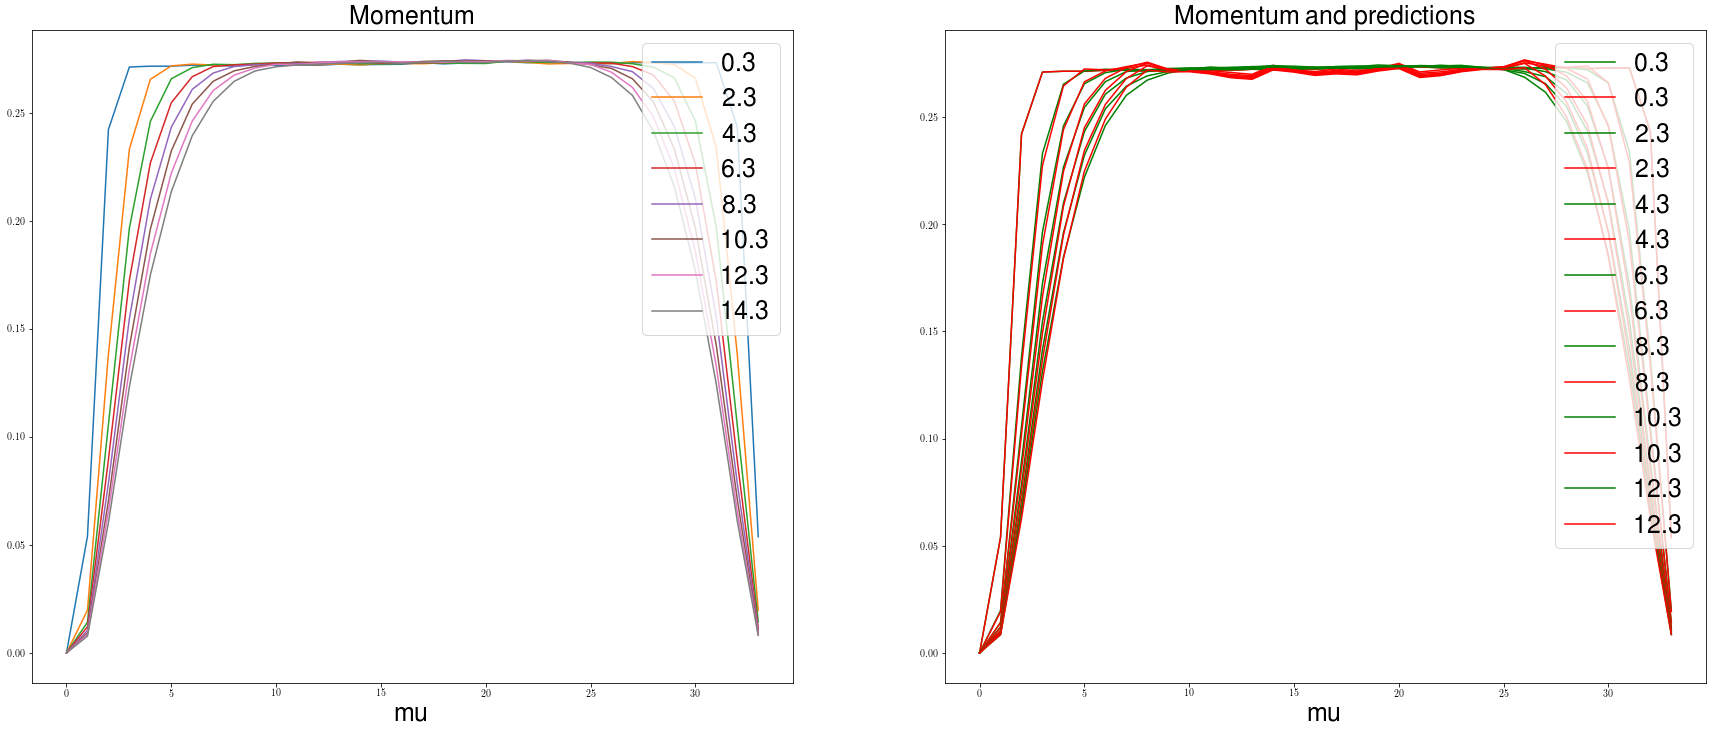

In [51]:
plt.figure(1, figsize=(30,12))

plt.subplot(121)
for k in np.arange(step(tau),step(15),500):
    plt.plot(gxt[k,:], label=str(k*dt))
    plt.xlabel('mu',fontsize=25)
    plt.legend(loc='upper right',fontsize=25)
    plt.title('Momentum',fontsize=25)

plt.subplot(122)
for k in np.arange(step(tau),step(14), step(2)):
    plt.plot(gxt[k,:],'g', label=str(k*dt))
    plt.plot(gxtPredict[k,:], 'r', label=str(k*dt))
    plt.legend(loc='upper right',fontsize=25)
    plt.xlabel('mu',fontsize=25)
    plt.title('Momentum and predictions',fontsize=25)
plt.show()

# 9. The boundary conditions

## 9.1 Compute $v_{\nu}(t)$ , $v_{\nu}^{\rm correct}(t)$, $P^B(t)$, $\frac{v_{\nu+1} - v_{\nu}}{\Delta z}$ and $\frac{1}{S}\frac{dP^B}{dt}$

$P^B(t) = \sum^B_{\mu=0}V_{bin}g_{\mu}(t)$

$v_{\nu}(t)=\frac{k_B \cdot T}{VBin}\cdot C^{-1}_{\mu\nu}(0) \cdot g_{\nu}(t)$

$v_{\nu}^{\rm correct}(t)=\frac{k_B \cdot T}{VBin}\cdot C^{-1}_{\mu\nu}(\tau) \cdot g_{\nu}(t)$

In [292]:
#C0Zeroed   = zeroedC(Ct[:,:,step(0)], 5e-6)
#CtauZeroed = zeroedC(Ct[:,:,step(tau)], 5e-6)

In [52]:
Velt        = np.zeros((nStepsPlugFlow, nNodes)) 
VeltCorrect = np.zeros((nStepsPlugFlow, nNodes)) 
for k in range(nStepsPlugFlow):
    Velt[k,:]        = (Temp / VBin) * CtInv[:,:,step(0)].dot(gxt[k,:])
    VeltCorrect[k,:] = (Temp / VBin) * CtInv[:,:,step(tau)].dot(gxt[k,:])
    #Velt[k,:]        = (Temp / VBin) * linalg.pinv(C0Zeroed, rcond=tol).dot(gxt[k,:])
    #VeltCorrect[k,:] = (Temp / VBin) * linalg.pinv(CtauZeroed, rcond=tol).dot(gxt[k,:])

PB0t = np.zeros(nStepsPlugFlow)
PB1t = np.zeros(nStepsPlugFlow)
PB2t = np.zeros(nStepsPlugFlow)
PB3t = np.zeros(nStepsPlugFlow)
for k in range(nStepsPlugFlow):
    PB0t[k] = VBin * np.sum(gxt[k,:1]) 
    PB1t[k] = VBin * np.sum(gxt[k,:2])
    PB2t[k] = VBin * np.sum(gxt[k,:3])
    PB3t[k] = VBin * np.sum(gxt[k,:4])

GradVelt = np.zeros((nStepsPlugFlow, nNodes))
GradVeltCorrect = np.zeros((nStepsPlugFlow, nNodes))
for i in range(nNodes-1):
    GradVelt[:,i] = Velt[:,i+1] - Velt[:,i]
    GradVeltCorrect[:,i] = VeltCorrect[:,i+1] - VeltCorrect[:,i]
GradVelt /= dz
GradVeltCorrect /= dz
 #v_{'18'}-v_{17}
GradVelt[:,-1] = - GradVelt[:,0] 
GradVeltCorrect[:,-1] = - GradVeltCorrect[:,0] 

PB0tDev = np.diff(PB0t) / dt
PB1tDev = np.diff(PB1t) / dt
PB2tDev = np.diff(PB2t) / dt
PB3tDev = np.diff(PB3t) / dt
PB0tDev = np.append(PB0tDev, PB0tDev[-1])
PB1tDev = np.append(PB1tDev, PB1tDev[-1])
PB2tDev = np.append(PB2tDev, PB2tDev[-1])
PB3tDev = np.append(PB3tDev, PB3tDev[-1])

#### Save files

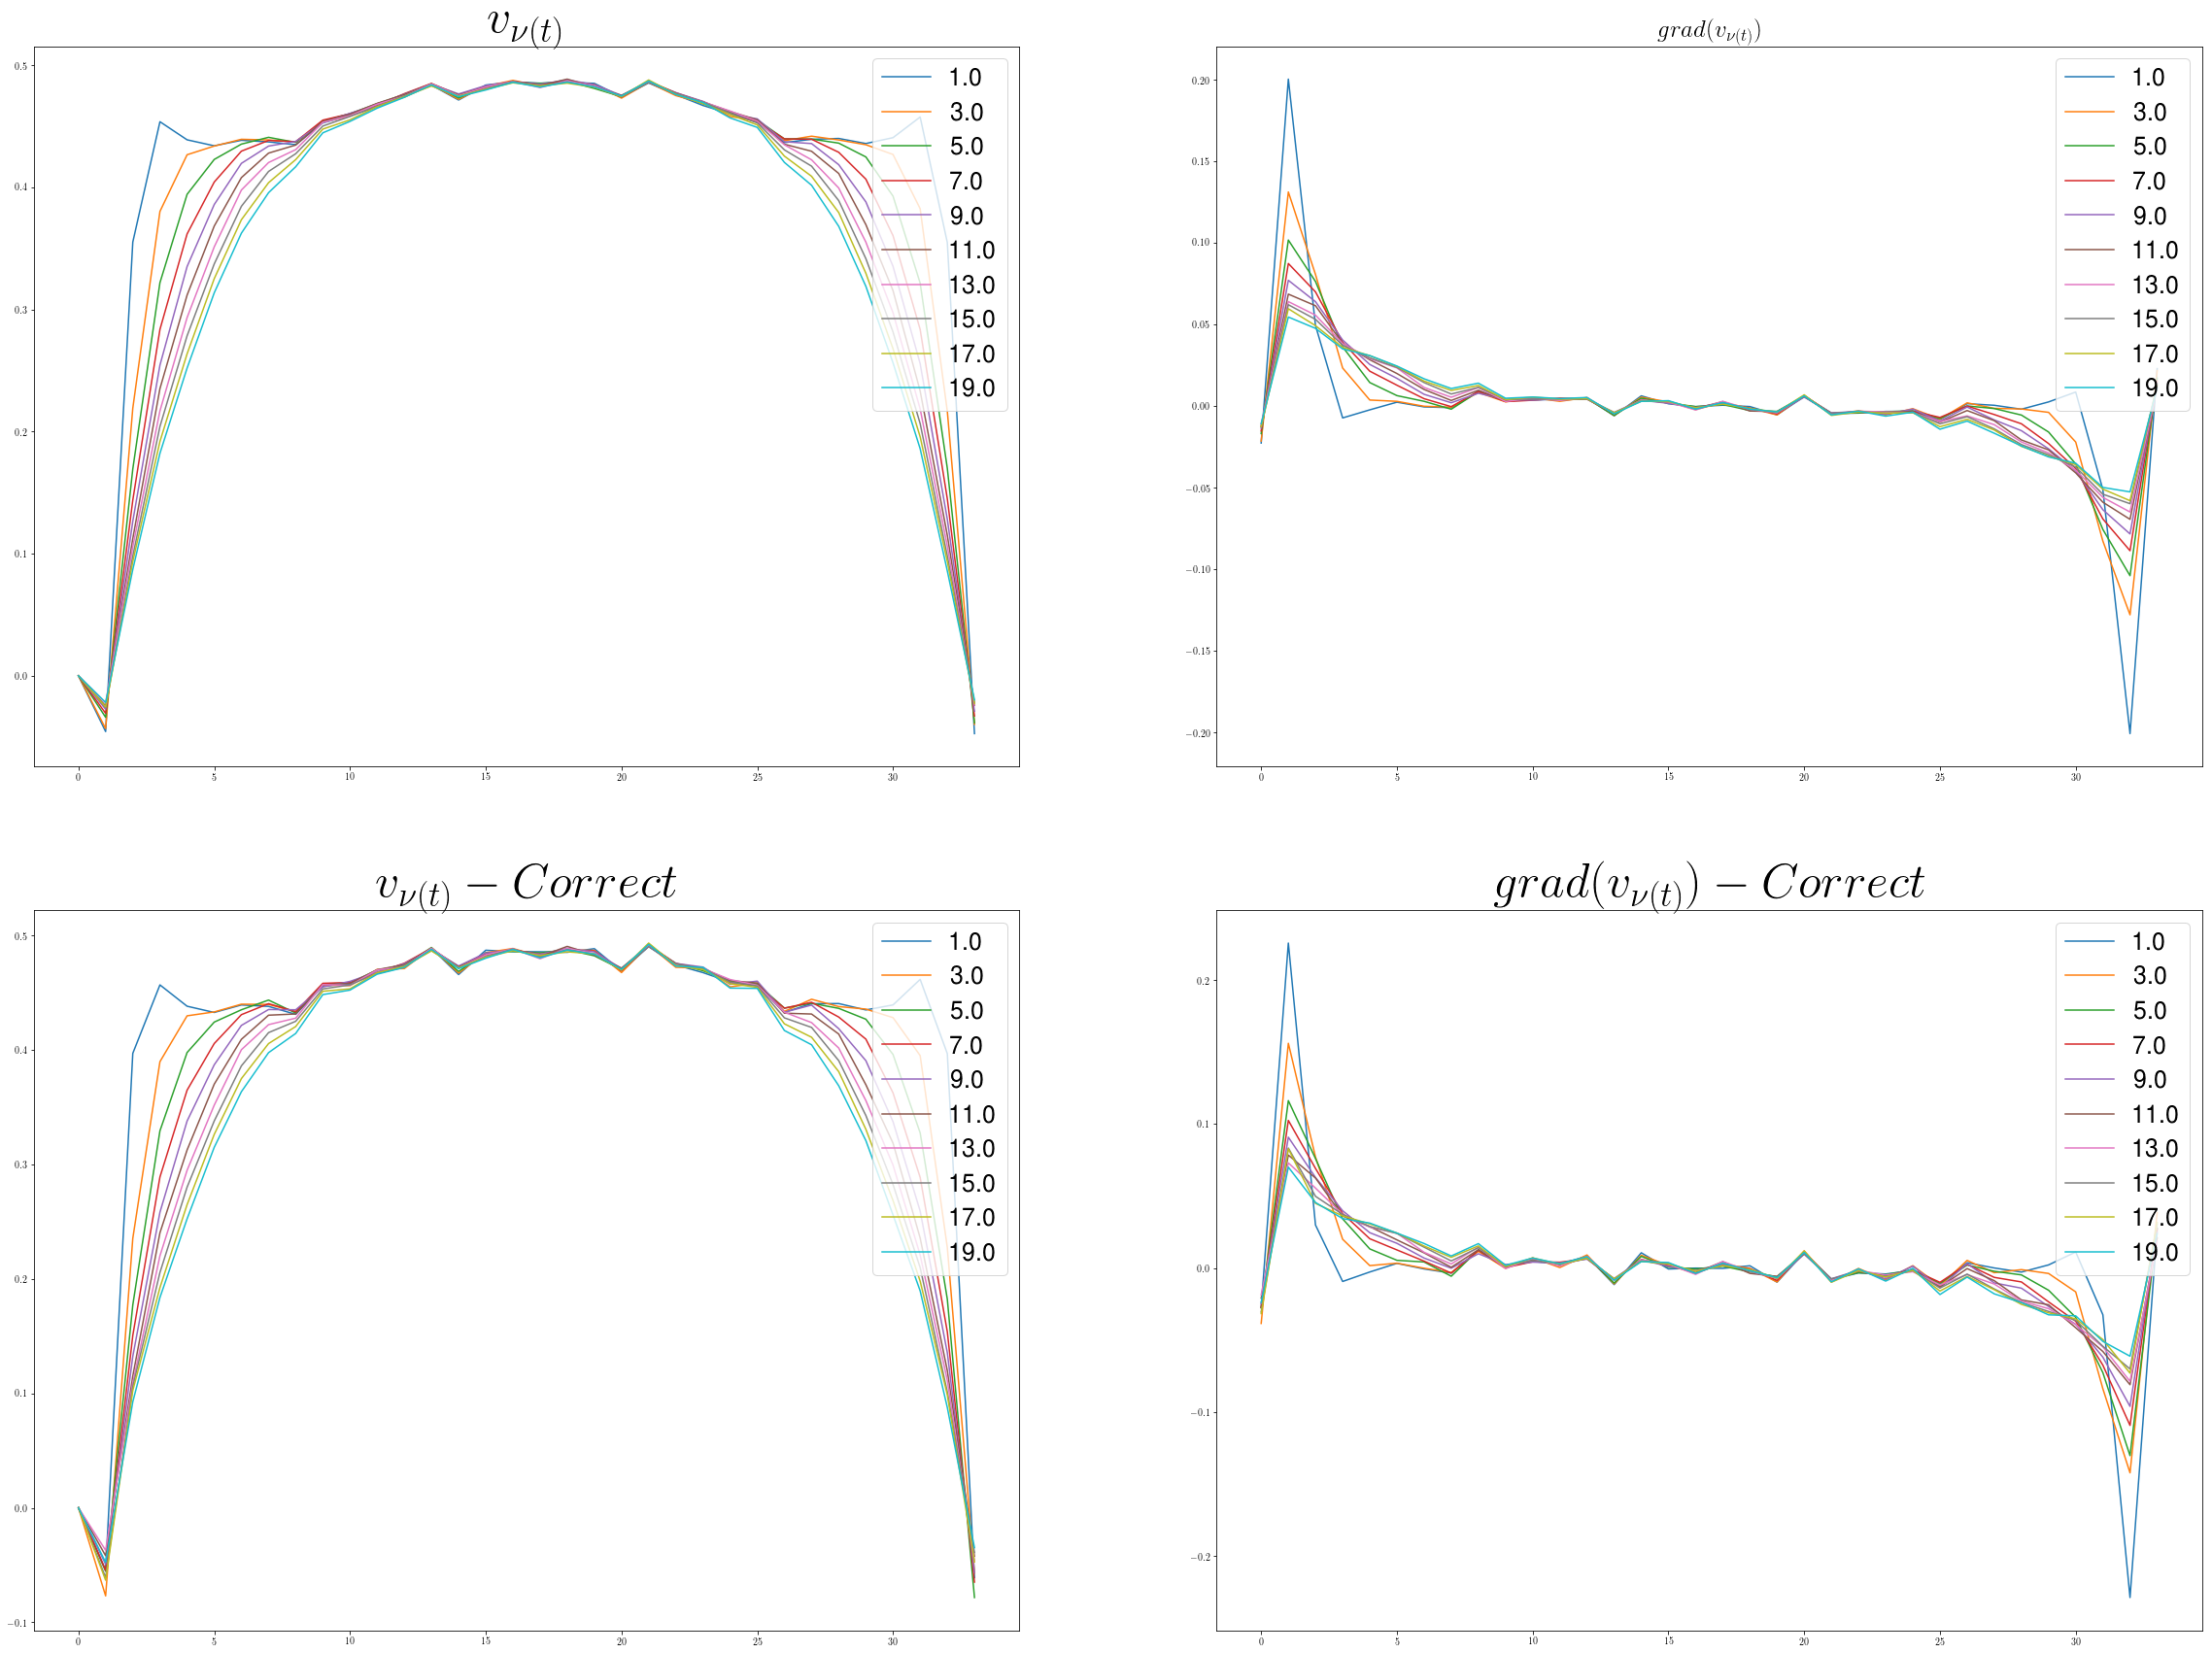

In [54]:
plt.figure(1, figsize=(40,30))

plt.subplot(221)
for k in np.arange(step(1),step(20),500):
    plt.plot(Velt[k,:], label=str(k*dt))
    #plt.axhline(y=0.5)
    plt.legend(loc='upper right',fontsize=25)
    plt.title(r'$v_{\nu(t)}$',fontsize=50)

plt.subplot(222)
for k in np.arange(step(1),step(20), 500):
    plt.plot(GradVelt[int(k),:], label=str(k*dt))
    plt.legend(loc='upper right',fontsize=25)
    plt.title(r'$grad(v_{\nu(t)})$',fontsize=25)

plt.subplot(223)
for k in np.arange(step(1),step(20),500):
    plt.plot(VeltCorrect[k,:], label=str(k*dt))
    plt.legend(loc='upper right',fontsize=25)
    plt.title(r'$v_{\nu(t)}-Correct$',fontsize=50)

plt.subplot(224)
for k in np.arange(step(1),step(20), 500):
    plt.plot(GradVeltCorrect[int(k),:], label=str(k*dt))
    plt.legend(loc='upper right',fontsize=25)
plt.title(r'$grad(v_{\nu(t)})-Correct$',fontsize=50)
plt.show()

## 9.2. Check mechanical balance

$\frac{1}{S}\frac{d P^B(t)}{dt} = \sum_{\nu=1}^M V_{bin}[\eta^*_{B\nu}-G^*_{\nu}]\frac{v_{\nu+1}-v_{\nu}}{\Delta z}-\sum_{\nu=1}^M V_{bin}(\gamma^*_{\nu}-H^*_{B\nu}v_{\nu})$

$\frac{1}{S}\frac{d P^B(t)}{dt} = test$

In [55]:
SPB0tDev = (1 / SBin) * PB0tDev
SPB1tDev = (1 / SBin) * PB1tDev
SPB2tDev = (1 / SBin) * PB2tDev
SPB3tDev = (1 / SBin) * PB3tDev

In [56]:
GNuB0     = (1 / SBin) * VBin * np.sum(G[:1, :],axis=0)
GammaNuB0 = (1 / SBin) * VBin * np.sum(Gamma[:1,:],axis=0)

GNuB1     = (1 / SBin) * VBin * np.sum(G[:2,:],axis=0)
GammaNuB1 = (1 / SBin) * VBin * np.sum(Gamma[:2,:],axis=0)

GNuB2     = (1 / SBin) * VBin * np.sum(G[:3,:],axis=0)
GammaNuB2 = (1 / SBin) * VBin * np.sum(Gamma[:3,:],axis=0)

GNuB3     = (1 / SBin) * VBin * np.sum(G[:4,:],axis=0)
GammaNuB3 = (1 / SBin) * VBin * np.sum(Gamma[:4,:],axis=0)

In [57]:
testB0t = np.zeros(nSteps)
testB1t = np.zeros(nSteps)
testB2t = np.zeros(nSteps)
testB3t = np.zeros(nSteps)

for k in range(nSteps):
    testB0t[k] = VBin * np.sum((Eta[0,:] - GNuB0) * GradVeltCorrect[k,:]) \
               - VBin * np.sum((GammaNuB0 - H[0,:]) * VeltCorrect[k,:])
    
    testB1t[k] = VBin * np.sum((Eta[1,:] - GNuB1) * GradVeltCorrect[k,:]) \
               - VBin * np.sum((GammaNuB1 - H[1,:]) * VeltCorrect[k,:])
    
    testB2t[k] = VBin * np.sum((Eta[2,:] - GNuB2) * GradVeltCorrect[k,:]) \
               - VBin * np.sum((GammaNuB2 - H[2,:])* VeltCorrect[k,:])
    
    testB3t[k] = VBin * np.sum((Eta[3,:] - GNuB3) * GradVeltCorrect[k,:]) \
               - VBin * np.sum((GammaNuB3 - H[3,:]) * VeltCorrect[k,:])

# # CUIDADO CON LOS PASOS DE TIEMPO. PLUGFLOW TIENE 7500 MIENTRAS QUE TENSOR Y FUERZA 500

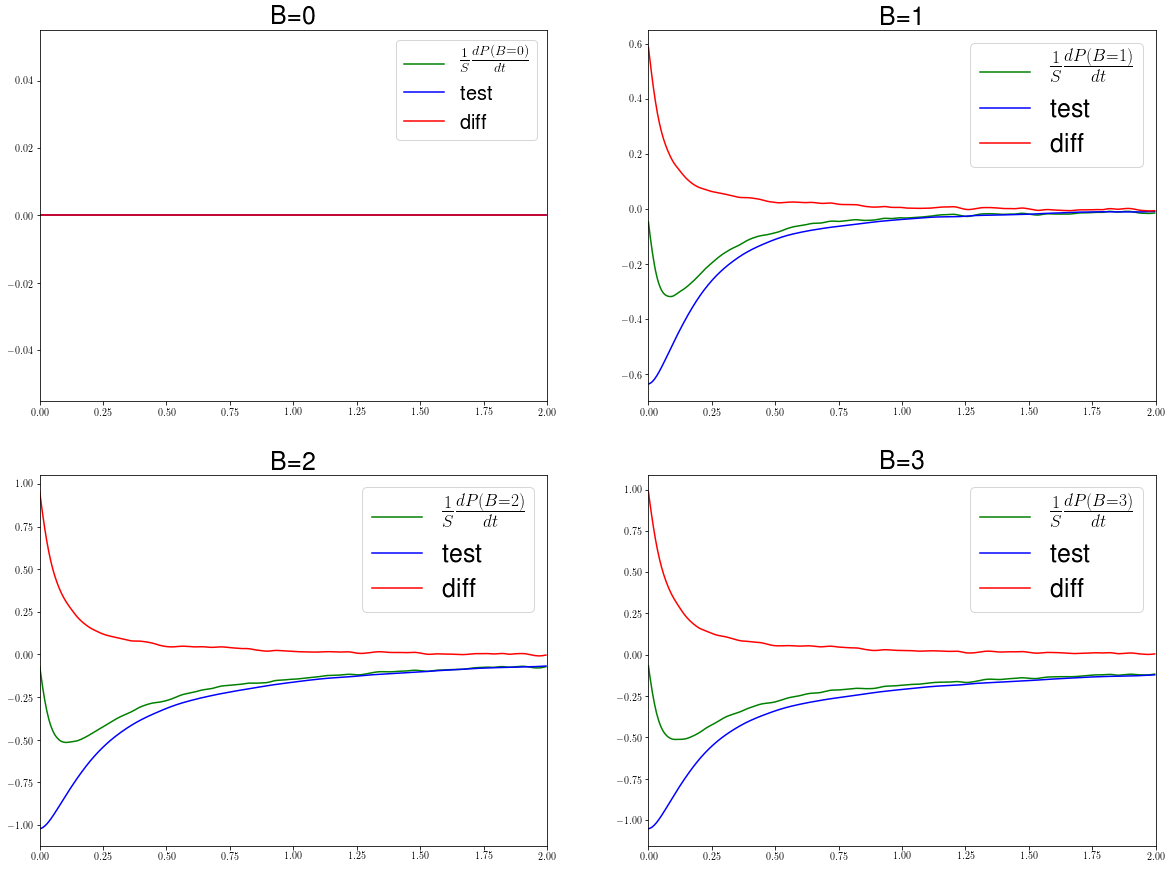

In [70]:
x = np.arange(0, nSteps * dt, dt)
plt.figure(1, figsize=(20,15))

plt.subplot(221)
plt.plot(x,SPB0tDev[:nSteps], 'g', label=r'$\frac{1}{S}\frac{dP(B=0)}{dt}$')
plt.plot(x,testB0t, 'b',  label='test')
plt.plot(x,SPB0tDev[:nSteps] - testB0t, color ='r', label='diff')
plt.title('B=0',fontsize=25)
#plt.axvline(x=tau, color ='k')
#plt.xlim(tau,5)
plt.xlim(0,2)
plt.legend(fontsize=20)

plt.subplot(222)
plt.plot(x,SPB1tDev[:nSteps], 'g', label=r'$\frac{1}{S}\frac{dP(B=1)}{dt}$')
plt.plot(x,testB1t, 'b',  label='test')
plt.plot(x,SPB1tDev[:nSteps] - testB1t, color ='r', label='diff')
#plt.axvline(x=tau, color ='k')
plt.title('B=1',fontsize=25)
#plt.xlim(tau,5)
plt.xlim(0,2)
plt.legend(fontsize=25)

plt.subplot(223)
plt.plot(x,SPB2tDev[:nSteps], 'g', label=r'$\frac{1}{S}\frac{dP(B=2)}{dt}$')
plt.plot(x,testB2t, 'b',  label='test')
plt.plot(x,SPB2tDev[:nSteps] - testB2t, color ='r', label='diff')
#plt.axvline(x=tau, color ='k')
plt.title('B=2',fontsize=25)
#plt.xlim(tau,5)
plt.xlim(0,2)
plt.legend(fontsize=25)

plt.subplot(224)
plt.plot(x,SPB3tDev[:nSteps], 'g', label=r'$\frac{1}{S}\frac{dP(B=3)}{dt}$')
plt.plot(x,testB3t, 'b',  label='test')
plt.plot(x,SPB3tDev[:nSteps] - testB3t, color ='r', label='diff')
#plt.axvline(x=tau, color ='k')
plt.title('B=3',fontsize=25)
#plt.xlim(tau,5)
plt.xlim(0,2)
plt.legend(fontsize=25)
plt.show()

## 9.3.  Slip length - computed with $\eta$, $G$, $H$ and $\gamma$, and the velocity 

In [71]:
GNuB0     = (1 / SBin) * VBin * np.sum(G[:1, :],axis=0)
GammaNuB0 = (1 / SBin) * VBin * np.sum(Gamma[:1,:],axis=0)

GNuB1     = (1 / SBin) * VBin * np.sum(G[:2,:],axis=0)
GammaNuB1 = (1 / SBin) * VBin * np.sum(Gamma[:2,:],axis=0)

GNuB2     = (1 / SBin) * VBin * np.sum(G[:3,:],axis=0)
GammaNuB2 = (1 / SBin) * VBin * np.sum(Gamma[:3,:],axis=0)

GNuB3     = (1 / SBin) * VBin * np.sum(G[:4,:],axis=0)
GammaNuB3 = (1 / SBin) * VBin * np.sum(Gamma[:4,:],axis=0)

In [72]:
zWallB1NumGK = 0 
zWallB2NumGK = 0
zWallB3NumGK = 0
zWallB1DenGK = 0 
zWallB2DenGK = 0
zWallB3DenGK = 0
for nu in range(1,nNodes):
    zWallB1NumGK += ((GammaNuB1[nu] - H[1,nu]) * nu) 
    zWallB1DenGK +=   GammaNuB1[nu] - H[1,nu]
    zWallB2NumGK += ((GammaNuB2[nu] - H[2,nu]) * nu) 
    zWallB2DenGK +=   GammaNuB2[nu] - H[2,nu]
    zWallB3NumGK += ((GammaNuB3[nu] - H[3,nu]) * nu) 
    zWallB3DenGK +=   GammaNuB3[nu] - H[3,nu]

zWallB1GK = (zWallB1NumGK / zWallB1DenGK) * dz
zWallB2GK = (zWallB2NumGK / zWallB2DenGK) * dz
zWallB3GK = (zWallB3NumGK / zWallB3DenGK) * dz

print 'zWallGK for B=1 ->', zWallB1GK
print 'zWallGK for B=2 ->', zWallB2GK
print 'zWallGK for B=3 ->', zWallB3GK

zWallGK for B=1 -> 2.8513027342
zWallGK for B=2 -> 2.94183512568
zWallGK for B=3 -> 2.80292044981


In [73]:
zWallGK  = 2.85
vtWallGK = VeltCorrect[:,1] + GradVeltCorrect[:,1] * (zWallGK - 1 * dz)
slipGK   = vtWallGK / GradVeltCorrect[:,1]

In [ ]:
#zWallGK  = 2.65
#vtWallGK = Velt[:,1] + GradVelt[:,1] * (zWallGK - 1 * dz)
#slipGK   = vtWallGK / GradVelt[:,1]

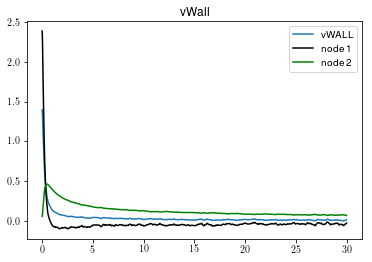

In [78]:
x = np.arange(0,nStepsPlugFlow*dt,dt)
plt.plot(x,vtWallGK, label = 'vWALL')
plt.plot(x,VeltCorrect[:,1], 'k', label = 'node 1')
plt.plot(x,VeltCorrect[:,2], 'g', label = 'node 2')
plt.title('vWall')
plt.legend()
plt.show()

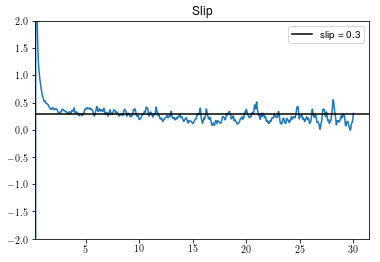

In [79]:
x = np.arange(0,nStepsPlugFlow*dt,dt)
plt.plot(x,slipGK)
#plt.xlim(0,0.05)
plt.axhline(y=0.3, color='k', linestyle='-', label='slip = 0.3')
plt.xlim(0.25,)
plt.ylim(-2,2)
plt.title('Slip')
plt.legend()
plt.show()
#np.savetxt('../filesGNUPLOT/slipGK-17nodes.dat', slipGK)

## 9.4.  Slip length - computed with $\eta'$ and $\gamma'$

In [81]:
EtaPrimaB1 = VBin * np.sum(Eta[1,:] - GNuB1)
EtaPrimaB2 = VBin * np.sum(Eta[2,:] - GNuB2)
EtaPrimaB3 = VBin * np.sum(Eta[3,:] - GNuB3)

GammaPrimaB1 = VBin * np.sum(GammaNuB1 - H[1,:])
GammaPrimaB2 = VBin * np.sum(GammaNuB2 - H[2,:])
GammaPrimaB3 = VBin * np.sum(GammaNuB3 - H[3,:])

DeltaB1 = EtaPrimaB1 / GammaPrimaB1
DeltaB2 = EtaPrimaB2 / GammaPrimaB2
DeltaB3 = EtaPrimaB3 / GammaPrimaB3

DeltaB1, DeltaB2, DeltaB3

(0.29921975516916288, 0.32936559924498732, 0.32841836564723048)

#### Save files

In [ ]:
plt.plot(np.sum(Gamma,axis=0))
plt.show()

In [ ]:
plt.plot(H[1,:])
plt.plot(H[2,:])
plt.plot(H[3,:])
plt.show()


plt.plot(GNuB1)
plt.plot(GNuB2)
plt.plot(GNuB3)
plt.show()
plt.plot(GammaNuB1)
plt.plot(GammaNuB2)
plt.plot(GammaNuB3)
plt.show()

In [ ]:
GammaTotalt = np.zeros(nSteps)
for k in range(nSteps):
    GammaTotalt[k] = (VBin**2 / SBin) * np.sum(Gammat[:,:,k])

In [ ]:
#np.savetxt('../../filesGNUPLOT/GammaTotal-WALLS-x2Box.dat', GammaTotalt)

In [ ]:
x = np.arange(0,nSteps*dt,dt)
plt.loglog(x,GammaTotalt)
plt.show()